## Load training data

In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
from itertools import repeat
from IPython.display import display, clear_output, set_matplotlib_formats
from pandas import DataFrame

from model.pre_process import pre_process
from model.segment_normaliser import normaliser_for_seg

%load_ext autoreload
%autoreload 2
%matplotlib inline

set_matplotlib_formats('png', 'pdf', quality=90)
n_hyperparam_trajs = 100
n_train_trajs = 60

plt.style.use('ggplot')
np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
random.shuffle(n_trajs)
train_traj_ids = frozenset(n_trajs[:n_train_trajs])
hyperparam_traj_ids = frozenset(n_trajs[n_train_trajs:(n_train_trajs + n_hyperparam_trajs)])
hyperparam_trajs = data[data.traj.transform(lambda j: j in hyperparam_traj_ids)]
train_trajs = data[data.traj.transform(lambda j: j in train_traj_ids)]
train_traj_ids = train_trajs.traj.unique()
train_seg_ids  = train_trajs.seg.unique()

# Segment normaliser
seg_dict = dict(tuple(data.groupby('seg')))
seg_normalisers = {
    seg_n: normaliser_for_seg(seg_dict[seg_n])
    for seg_n in seg_dict
}


def load_seg(df: DataFrame, seg_n: int, traj_n: int, frac_observed=1):
    print('loading segment', seg_n, traj_n, frac_observed)
    return pre_process(
        df[(df.traj == traj_n) & (df.seg == seg_n)], 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        frac_observed
    )

def from_km(km):
    return km*1000
    
def from_km_h(km_h):
    """To m/s"""
    return km_h/3.6

stop_compress_delta  = 4 # meters
f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
f_p_sigma_n =  .1  # meters
f_v_sigma_n = from_km_h(.00001) # m/s
g_sigma_n = .0001 # tau is deterministic
h_sigma_n = 1 # seconds
delta_xy = 4 # metres, spatial cluster width
delta_p = 4#  metres, p cluster width
delta_v = from_km_h(.5)   # metres/second, v cluster width
route_n = 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Estiamte Priors

In [6]:
from model.function_model import learn_function
from model.trajectory_model import learn_model
import GPy

rbf_kernel = lambda: GPy.kern.RBF(1) 
matern_kernel = lambda: GPy.kern.Matern32(1) 
hyp_traj_ids = hyperparam_trajs.traj.unique()
hyp_seg_ids  = hyperparam_trajs.seg.unique()
fpx_ls, fpy_ls, fvx_ls, fvy_ls = [], [], [], []
fpx_var, fpy_var, fvx_var, fvy_var = [], [], [], []

ls = np.ndarray((6, len(hyp_seg_ids), len(hyp_traj_ids)))
vars = np.ndarray((6, len(hyp_seg_ids), len(hyp_traj_ids)))
lins = np.ndarray((2, len(hyp_seg_ids), len(hyp_traj_ids)))
for i, seg_id in enumerate(hyp_seg_ids):
    for j, traj_id in enumerate(hyp_traj_ids):
        seg = load_seg(hyperparam_trajs, seg_id, traj_id)
        normaliser = seg_normalisers[seg_id]
        scaled_f_p_sigma_n =  f_p_sigma_n / normaliser.p_scale 
        scaled_f_v_sigma_n = f_v_sigma_n / normaliser.v_scale
        scaled_delta_xy = delta_xy / normaliser.p_scale
        scaled_delta_p = delta_p / normaliser.p_scale
        scaled_delta_v = delta_v / normaliser.v_scale
        tau = seg.tau.values.reshape(-1, 1)
        x = seg.x.values.reshape(-1, 1)
        y = seg.y.values.reshape(-1, 1)
        dx = seg.dx.values.reshape(-1, 1)
        dy = seg.dy.values.reshape(-1, 1)
        time_left = seg.time_left.values.reshape(-1, 1)
        fpx = learn_function(tau, x, rbf_kernel(), f_p_sigma_n, n_restarts=3)
        ls[0, i, j] = fpx.model.rbf.lengthscale
        vars[0, i, j] = fpx.model.rbf.variance
        
        fpy = learn_function(tau, y, rbf_kernel(), f_p_sigma_n, n_restarts=3)
        ls[1, i, j] = fpy.model.rbf.lengthscale
        vars[1, i, j] = fpy.model.rbf.variance
        
        fvx = learn_function(tau, dx, matern_kernel(), f_v_sigma_n, n_restarts=3)
        ls[2, i, j] = fvx.model.kern.lengthscale
        vars[2, i, j] = fvx.model.kern.variance
        
        fvy = learn_function(tau, dy, matern_kernel(), f_v_sigma_n, n_restarts=3)
        ls[3, i, j] = fvy.model.kern.lengthscale
        vars[3, i, j] = fvy.model.kern.variance

        g = learn_function(np.hstack((x, y)), tau, GPy.kern.RBF(2) + GPy.kern.Linear(2), g_sigma_n, n_restarts=3)
        ls[4, i, j] = g.model.sum.rbf.lengthscale
        vars[4, i, j] = g.model.sum.rbf.variance
        lins[0, i, j] = g.model.sum.linear.variances
        
        h = learn_function(tau, time_left, GPy.kern.RBF(1) + GPy.kern.Linear(1), g_sigma_n, n_restarts=3)
        ls[5, i, j] = h.model.sum.rbf.lengthscale
        vars[5, i, j] = h.model.sum.rbf.variance
        lins[1, i, j] = h.model.sum.linear.variances


loading segment 1 24 1
Optimization restart 1/3, f = 0.271993428094107
Optimization restart 2/3, f = 0.2719934275100959
Optimization restart 3/3, f = 0.2719934275109601
Optimization restart 1/3, f = -8.01235898855449
Optimization restart 2/3, f = -8.012358988475379
Optimization restart 3/3, f = -8.012358988556118
Optimization restart 1/3, f = -15.770692486157788
Optimization restart 2/3, f = -15.770692486160584
Optimization restart 3/3, f = -15.7706924861615
Optimization restart 1/3, f = -133.89774014261843
Optimization restart 2/3, f = -133.89774014262642
Optimization restart 3/3, f = -133.89774014137942
Optimization restart 1/3, f = -148.34261513394657
Optimization restart 2/3, f = -148.34261516580798
Optimization restart 3/3, f = -148.34260794912976
Optimization restart 1/3, f = 74.66826903565608
Optimization restart 2/3, f = 74.55118347176848
Optimization restart 3/3, f = 74.93264366177323
loading segment 1 33 1
Optimization restart 1/3, f = -1.1938112204256077
Optimization restart

Optimization restart 1/3, f = -2.230691395159375
Optimization restart 2/3, f = -2.2306913951485656
Optimization restart 3/3, f = -2.2306913951490355
Optimization restart 1/3, f = -10.173000652252897
Optimization restart 2/3, f = -10.173000652218075
Optimization restart 3/3, f = -10.173000652253213
Optimization restart 1/3, f = -79.90358813683608
Optimization restart 2/3, f = -79.90358813685478
Optimization restart 3/3, f = -79.90358813685451
Optimization restart 1/3, f = -208.85458284595947
Optimization restart 2/3, f = -208.85458292412935
Optimization restart 3/3, f = -208.85458292414046
Optimization restart 1/3, f = -178.53660396351924
Optimization restart 2/3, f = -178.53660558445452
Optimization restart 3/3, f = -178.53660522020374
Optimization restart 1/3, f = 325.7227725797621
Optimization restart 2/3, f = 110.92548604237257
Optimization restart 3/3, f = 110.79786299241779
loading segment 1 261 1
Optimization restart 1/3, f = 0.27540343738822237
Optimization restart 2/3, f = 0.27

Optimization restart 2/3, f = 1.1778042251673435
Optimization restart 3/3, f = 1.177804225166804
Optimization restart 1/3, f = -6.402289217110828
Optimization restart 2/3, f = -6.402289217110734
Optimization restart 3/3, f = -6.402289217067651
Optimization restart 1/3, f = -43.83444436861775
Optimization restart 2/3, f = -43.83444436795239
Optimization restart 3/3, f = -43.83444436863745
Optimization restart 1/3, f = -146.6467643458375
Optimization restart 2/3, f = -146.64676434555582
Optimization restart 3/3, f = -146.64676434572704
Optimization restart 1/3, f = -111.53869306369523
Optimization restart 2/3, f = -111.53868641724719
Optimization restart 3/3, f = -111.53869363493929
Optimization restart 1/3, f = 59.55888656521839
Optimization restart 2/3, f = 59.5588865657076
Optimization restart 3/3, f = 213.37677296017762
loading segment 1 620 1
Optimization restart 1/3, f = 0.6258054420244421
Optimization restart 2/3, f = 0.6258054420060364
Optimization restart 3/3, f = 0.625805442139

Optimization restart 2/3, f = -143.74342877712087
Optimization restart 3/3, f = -143.74342877711135
Optimization restart 1/3, f = -139.9422521265301
Optimization restart 2/3, f = -139.9422522969748
Optimization restart 3/3, f = -139.94225217099088
Optimization restart 1/3, f = 60.089890552120586
Optimization restart 2/3, f = 60.08989054539684
Optimization restart 3/3, f = 60.089890553613486
loading segment 1 1146 1
Optimization restart 1/3, f = 0.3694476514340863
Optimization restart 2/3, f = 0.3694476514295535
Optimization restart 3/3, f = 0.3694476514294611
Optimization restart 1/3, f = -7.116062933032318
Optimization restart 2/3, f = -7.116062933032509
Optimization restart 3/3, f = -7.116062933032486
Optimization restart 1/3, f = -17.19194177237456
Optimization restart 2/3, f = -17.191941772350756
Optimization restart 3/3, f = -17.191941772369233
Optimization restart 1/3, f = -117.20342758743908
Optimization restart 2/3, f = -117.20342758740688
Optimization restart 3/3, f = -117.203

Optimization restart 3/3, f = -157.2040596712782
Optimization restart 1/3, f = 84.3463589036812
Optimization restart 2/3, f = 296.2048931078044
Optimization restart 3/3, f = 296.2048910657342
loading segment 1 1265 1
Optimization restart 1/3, f = -2.448293991181191
Optimization restart 2/3, f = -2.44829399109955
Optimization restart 3/3, f = -2.448293991181364
Optimization restart 1/3, f = -10.056599600417048
Optimization restart 2/3, f = -10.056599600417355
Optimization restart 3/3, f = -10.056599600401727
Optimization restart 1/3, f = -113.99288100010358
Optimization restart 2/3, f = -113.9928809995656
Optimization restart 3/3, f = -113.99288100004235
Optimization restart 1/3, f = -236.44418274214866
Optimization restart 2/3, f = -236.44418273973938
Optimization restart 3/3, f = -236.44418274214613
Optimization restart 1/3, f = -177.74693250050646
Optimization restart 2/3, f = -177.74693403275825
Optimization restart 3/3, f = -177.74693422649196
Optimization restart 1/3, f = 47.69236

Optimization restart 2/3, f = 30.415545432165676
Optimization restart 3/3, f = 30.413227113634743
loading segment 1 1790 1
Optimization restart 1/3, f = -0.1484088678566966
Optimization restart 2/3, f = -0.1484088678180342
Optimization restart 3/3, f = -0.14840886505391726
Optimization restart 1/3, f = -7.976286471725564
Optimization restart 2/3, f = -7.976286471731814
Optimization restart 3/3, f = -7.976286471731901
Optimization restart 1/3, f = -53.95510084526019
Optimization restart 2/3, f = -53.95510084302519
Optimization restart 3/3, f = -53.95510084523431
Optimization restart 1/3, f = -166.20188483651185
Optimization restart 2/3, f = -166.2018848365572
Optimization restart 3/3, f = -166.2018848365286
Optimization restart 1/3, f = -137.43381679166674
Optimization restart 2/3, f = -137.43381346366948
Optimization restart 3/3, f = -137.43381674782688
Optimization restart 1/3, f = 58.966591944876505
Optimization restart 2/3, f = 258.46206923585305
Optimization restart 3/3, f = 258.46

Optimization restart 2/3, f = 71.13977767644508
Optimization restart 3/3, f = 258.0727326826739
loading segment 1 2115 1
Optimization restart 1/3, f = 0.7882410251503758
Optimization restart 2/3, f = 0.7882410251490439
Optimization restart 3/3, f = 0.7882410251490652
Optimization restart 1/3, f = -7.0859418520326525
Optimization restart 2/3, f = -7.0859418520331
Optimization restart 3/3, f = -7.085941852033097
Optimization restart 1/3, f = -32.26279614718182
Optimization restart 2/3, f = -32.26279614718661
Optimization restart 3/3, f = -32.262796147098
Optimization restart 1/3, f = -146.22642786250572
Optimization restart 2/3, f = -146.2264278626794
Optimization restart 3/3, f = -146.22642786267386
Optimization restart 1/3, f = -121.84867338693121
Optimization restart 2/3, f = -121.84867345542753
Optimization restart 3/3, f = -121.84867304222516
Optimization restart 1/3, f = 54.94757845992164
Optimization restart 2/3, f = 54.94757840764888
Optimization restart 3/3, f = 54.9475784008048

Optimization restart 2/3, f = 56.9726209596419
Optimization restart 3/3, f = 56.972620960510355
loading segment 1 2398 1
Optimization restart 1/3, f = 0.7029760027286645
Optimization restart 2/3, f = 0.7029760027302432
Optimization restart 3/3, f = 0.7029760027307077
Optimization restart 1/3, f = -6.999517328720112
Optimization restart 2/3, f = -6.999517328718378
Optimization restart 3/3, f = -6.999517328703955
Optimization restart 1/3, f = -43.751607969474
Optimization restart 2/3, f = -43.751607969473554
Optimization restart 3/3, f = -43.75160796946518
Optimization restart 1/3, f = -136.86753407256998
Optimization restart 2/3, f = -136.86753407256654
Optimization restart 3/3, f = -136.86753407256788
Optimization restart 1/3, f = -127.303635182598
Optimization restart 2/3, f = -127.30364702980233
Optimization restart 3/3, f = -127.30364705494289
Optimization restart 1/3, f = 51.645276227703036
Optimization restart 2/3, f = 51.58994090559332
Optimization restart 3/3, f = 51.58493723109

Optimization restart 1/3, f = -0.13972988904958195
Optimization restart 2/3, f = -0.1397298890495886
Optimization restart 3/3, f = -0.13972988896993765
Optimization restart 1/3, f = -8.400769566783204
Optimization restart 2/3, f = -8.400769566769132
Optimization restart 3/3, f = -8.400769566788126
Optimization restart 1/3, f = -36.687693301788954
Optimization restart 2/3, f = -36.68769330150195
Optimization restart 3/3, f = -36.68769330179506
Optimization restart 1/3, f = -168.71009630864214
Optimization restart 2/3, f = -168.71009631875327
Optimization restart 3/3, f = -168.71009631876092
Optimization restart 1/3, f = -146.92697906288294
Optimization restart 2/3, f = -146.92698069516345
Optimization restart 3/3, f = -146.92697881368798
Optimization restart 1/3, f = 275.8047257373414
Optimization restart 2/3, f = 63.030454684717185
Optimization restart 3/3, f = 63.03045470159172
loading segment 1 2690 1
Optimization restart 1/3, f = 1.2973042890656696
Optimization restart 2/3, f = 1.29

Optimization restart 2/3, f = -6.774712557612488
Optimization restart 3/3, f = -6.774712557688325
Optimization restart 1/3, f = -8.786715009124535
Optimization restart 2/3, f = -8.786715009121924
Optimization restart 3/3, f = -8.78671500912279
Optimization restart 1/3, f = -151.85062575035704
Optimization restart 2/3, f = -151.85062575035303
Optimization restart 3/3, f = -151.8506257496011
Optimization restart 1/3, f = -120.21819672640711
Optimization restart 2/3, f = -120.21819663256841
Optimization restart 3/3, f = -120.2181962804173
Optimization restart 1/3, f = 140.3956886081969
Optimization restart 2/3, f = 140.56898181029072
Optimization restart 3/3, f = 140.5864798331665
loading segment 1 2909 1
Optimization restart 1/3, f = 0.11467021582052261
Optimization restart 2/3, f = 0.11467021582675496
Optimization restart 3/3, f = 0.1146702158176951
Optimization restart 1/3, f = -8.218675275449948
Optimization restart 2/3, f = -8.21867527500078
Optimization restart 3/3, f = -8.218675275

Optimization restart 3/3, f = -157.70884112555984
Optimization restart 1/3, f = -131.7984577234587
Optimization restart 2/3, f = -131.79843768431775
Optimization restart 3/3, f = -131.79844782603047
Optimization restart 1/3, f = 53.175534845921256
Optimization restart 2/3, f = 259.6885653842576
Optimization restart 3/3, f = 259.68856537342174
loading segment 1 3309 1
Optimization restart 1/3, f = 0.386871529936637
Optimization restart 2/3, f = 0.3868715299335914
Optimization restart 3/3, f = 0.3868715299907519
Optimization restart 1/3, f = -7.575616827679789
Optimization restart 2/3, f = -7.575616827680664
Optimization restart 3/3, f = -7.575616827704164
Optimization restart 1/3, f = -50.504471215351785
Optimization restart 2/3, f = -50.50447121536892
Optimization restart 3/3, f = -50.504471211568905
Optimization restart 1/3, f = -166.70413118133428
Optimization restart 2/3, f = -166.70413118132635
Optimization restart 3/3, f = -166.70413118132123
Optimization restart 1/3, f = -139.010

Optimization restart 1/3, f = 122.06157731063172
Optimization restart 2/3, f = 121.993284156039
Optimization restart 3/3, f = 122.06670840410922
loading segment 2 33 1
Optimization restart 1/3, f = 0.25227831928242317
Optimization restart 2/3, f = 0.2522783193183087
Optimization restart 3/3, f = 0.2522783192854827
Optimization restart 1/3, f = -3.8139428032915488
Optimization restart 2/3, f = -3.813942803276702
Optimization restart 3/3, f = -3.8139428032986467
Optimization restart 1/3, f = 0.41888350410527764
Optimization restart 2/3, f = 0.41888350410515685
Optimization restart 3/3, f = 0.418883504105505
Optimization restart 1/3, f = -97.19328460208625
Optimization restart 2/3, f = -97.19328460224436
Optimization restart 3/3, f = -97.1932846022444
Optimization restart 1/3, f = -110.9494620186799
Optimization restart 2/3, f = -110.94946201865622
Optimization restart 3/3, f = -110.94946201875528
Optimization restart 1/3, f = 119.62219403468119
Optimization restart 2/3, f = 119.689927598

Optimization restart 3/3, f = 253.25626828496496
loading segment 2 261 1
Optimization restart 1/3, f = 0.04540787286621151
Optimization restart 2/3, f = 0.04540787280439518
Optimization restart 3/3, f = 0.045407872825312445
Optimization restart 1/3, f = -3.789762254246471
Optimization restart 2/3, f = -3.7897622542532083
Optimization restart 3/3, f = -3.789762254252069
Optimization restart 1/3, f = -3.004384905449143
Optimization restart 2/3, f = -3.0043849054492817
Optimization restart 3/3, f = -3.004384905449065
Optimization restart 1/3, f = -100.14097479027934
Optimization restart 2/3, f = -100.14097479027117
Optimization restart 3/3, f = -100.14097479026236
Optimization restart 1/3, f = -105.6571434975804
Optimization restart 2/3, f = -105.65714349757808
Optimization restart 3/3, f = -105.65714349757305
Optimization restart 1/3, f = 109.77206057355676
Optimization restart 2/3, f = 169.04517863011648
Optimization restart 3/3, f = 109.65804479001866
loading segment 2 284 1
Optimizati

Optimization restart 3/3, f = 0.5515686545457208
Optimization restart 1/3, f = -3.4825874945460535
Optimization restart 2/3, f = -3.4825874945456365
Optimization restart 3/3, f = -3.4825874945272295
Optimization restart 1/3, f = -0.7903308314037147
Optimization restart 2/3, f = -0.7903308314044892
Optimization restart 3/3, f = -0.7903308314041588
Optimization restart 1/3, f = -92.57286855164188
Optimization restart 2/3, f = -92.57286855171978
Optimization restart 3/3, f = -92.57286855171867
Optimization restart 1/3, f = -101.50288278597478
Optimization restart 2/3, f = -101.50288278597456
Optimization restart 3/3, f = -101.50288278584503
Optimization restart 1/3, f = 88.93349146453318
Optimization restart 2/3, f = 88.81487922909007
Optimization restart 3/3, f = 88.825314880754
loading segment 2 696 1
Optimization restart 1/3, f = 0.39463625700537275
Optimization restart 2/3, f = 0.39463625822372217
Optimization restart 3/3, f = 0.39463625699897587
Optimization restart 1/3, f = -3.14833

Optimization restart 2/3, f = -11.403304959750368
Optimization restart 3/3, f = -11.4033049599335
Optimization restart 1/3, f = -124.81904384401265
Optimization restart 2/3, f = -124.81904384394684
Optimization restart 3/3, f = -124.81904384401625
Optimization restart 1/3, f = -130.00612193631787
Optimization restart 2/3, f = -130.00612193582893
Optimization restart 3/3, f = -130.75214103641034
Optimization restart 1/3, f = 120.75946373264765
Optimization restart 2/3, f = 199.41615663277682
Optimization restart 3/3, f = 120.75946373098039
loading segment 2 1158 1
Optimization restart 1/3, f = -0.6807250363286799
Optimization restart 2/3, f = -0.6807250363413622
Optimization restart 3/3, f = -0.6807250363065682
Optimization restart 1/3, f = -4.861027515866772
Optimization restart 2/3, f = -4.861027515846077
Optimization restart 3/3, f = -4.861027515871834
Optimization restart 1/3, f = -15.930671411114599
Optimization restart 2/3, f = -15.93067140956374
Optimization restart 3/3, f = -15.

Optimization restart 1/3, f = -179.22563206712306
Optimization restart 2/3, f = -179.22563206383947
Optimization restart 3/3, f = -179.2256320703796
Optimization restart 1/3, f = 168.9695575273002
Optimization restart 2/3, f = 169.4767480255728
Optimization restart 3/3, f = 168.96955752091608
loading segment 2 1267 1
Optimization restart 1/3, f = -0.1643034489901627
Optimization restart 2/3, f = -0.16430344899390237
Optimization restart 3/3, f = -0.16430344898423677
Optimization restart 1/3, f = -4.191335388053959
Optimization restart 2/3, f = -4.191335388068377
Optimization restart 3/3, f = -4.1913353880682545
Optimization restart 1/3, f = -8.503412560183207
Optimization restart 2/3, f = -8.503412559990405
Optimization restart 3/3, f = -8.503412560182895
Optimization restart 1/3, f = -110.28885915408199
Optimization restart 2/3, f = -110.28885915415759
Optimization restart 3/3, f = -110.28885915418235
Optimization restart 1/3, f = -112.13764909655359
Optimization restart 2/3, f = -112

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:454: RuntimeWarning:overflow encountered in multiply
 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\stationary.py:454: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/3, f = -105.2743348093507
Optimization restart 2/3, f = -105.2743348092969
Optimization restart 3/3, f = -105.27433480912968
Optimization restart 1/3, f = 132.50429504873222
Optimization restart 2/3, f = 132.49475686162685
Optimization restart 3/3, f = 182.05233895781015
loading segment 2 1332 1
Optimization restart 1/3, f = -0.245712961895739
Optimization restart 2/3, f = -0.24571296189659542
Optimization restart 3/3, f = -0.24571296189655256
Optimization restart 1/3, f = -4.090762803276156
Optimization restart 2/3, f = -4.090762803275908
Optimization restart 3/3, f = -4.090762803261598
Optimization restart 1/3, f = -8.844658610681236
Optimization restart 2/3, f = -8.844658610682274
Optimization restart 3/3, f = -8.844658610682043
Optimization restart 1/3, f = -108.63042033673739
Optimization restart 2/3, f = -108.63042033811712
Optimization restart 3/3, f = -108.63042033813811
Optimization restart 1/3, f = -113.59452546241766
Optimization restart 2/3, f = -113.

Optimization restart 1/3, f = 119.1423519286985
Optimization restart 2/3, f = 119.01314860265981
Optimization restart 3/3, f = 118.91513603546932
loading segment 2 1840 1
Optimization restart 1/3, f = 0.5733828047568379
Optimization restart 2/3, f = 0.5733828047906926
Optimization restart 3/3, f = 0.5733828047860825
Optimization restart 1/3, f = -3.5255841772911904
Optimization restart 2/3, f = -3.525584177297813
Optimization restart 3/3, f = -3.525584177298312
Optimization restart 1/3, f = -4.460536594760075
Optimization restart 2/3, f = -4.460536594763536
Optimization restart 3/3, f = -4.460536594753581
Optimization restart 1/3, f = -99.04791692300627
Optimization restart 2/3, f = -99.04791692298909
Optimization restart 3/3, f = -99.04791692300837
Optimization restart 1/3, f = -104.47972598310703
Optimization restart 2/3, f = -104.47972598313618
Optimization restart 3/3, f = -104.47972598314551
Optimization restart 1/3, f = 90.55773024107083
Optimization restart 2/3, f = 90.557730241

loading segment 2 2250 1
Optimization restart 1/3, f = 0.4672005406628563
Optimization restart 2/3, f = 0.4672005405847872
Optimization restart 3/3, f = 0.4672005406275299
Optimization restart 1/3, f = -3.455625358785727
Optimization restart 2/3, f = -3.455625358794064
Optimization restart 3/3, f = -3.455625358769547
Optimization restart 1/3, f = -6.556126819070155
Optimization restart 2/3, f = -6.556126819069799
Optimization restart 3/3, f = -6.55612681907029
Optimization restart 1/3, f = -99.47105513087895
Optimization restart 2/3, f = -99.47105513085863
Optimization restart 3/3, f = -99.47105513087875
Optimization restart 1/3, f = -97.41048554261768
Optimization restart 2/3, f = -97.41048554263014
Optimization restart 3/3, f = -97.41048554262085
Optimization restart 1/3, f = 96.03960596522424
Optimization restart 2/3, f = 96.15557819270944
Optimization restart 3/3, f = 157.03823825383355
loading segment 2 2268 1
Optimization restart 1/3, f = 0.7616087476915498
Optimization restart 2

Optimization restart 1/3, f = -0.24671809954034574
Optimization restart 2/3, f = -0.24671809953691337
Optimization restart 3/3, f = -0.24671809954491275
Optimization restart 1/3, f = -4.347569211227517
Optimization restart 2/3, f = -4.3475692112229485
Optimization restart 3/3, f = -4.347569211221558
Optimization restart 1/3, f = -14.295923101424197
Optimization restart 2/3, f = -14.295923101467224
Optimization restart 3/3, f = -14.295923101439623
Optimization restart 1/3, f = -120.77452610201634
Optimization restart 2/3, f = -120.7745261020337
Optimization restart 3/3, f = -120.77452610203392
Optimization restart 1/3, f = -114.17558985953053
Optimization restart 2/3, f = -114.17558985950978
Optimization restart 3/3, f = -114.17558985951456
Optimization restart 1/3, f = 122.20716780436656
Optimization restart 2/3, f = 122.23368230920902
Optimization restart 3/3, f = 122.36071530501471
loading segment 2 2579 1
Optimization restart 1/3, f = 0.7571502102155689
Optimization restart 2/3, f =

Optimization restart 1/3, f = 0.7286170040911428
Optimization restart 2/3, f = 0.7286170041017066
Optimization restart 3/3, f = 0.7286170040930167
Optimization restart 1/3, f = -3.2456328998579433
Optimization restart 2/3, f = -3.245632899870312
Optimization restart 3/3, f = -3.2456328995272172
Optimization restart 1/3, f = 1.87444994323835
Optimization restart 2/3, f = 1.8744499432376323
Optimization restart 3/3, f = 1.8744499432371384
Optimization restart 1/3, f = -86.99858864209463
Optimization restart 2/3, f = -86.99858864209459
Optimization restart 3/3, f = -86.99858864202515
Optimization restart 1/3, f = -99.52640584618098
Optimization restart 2/3, f = -99.52640584618537
Optimization restart 3/3, f = -99.52640584618264
Optimization restart 1/3, f = 78.6360619562121
Optimization restart 2/3, f = 78.63606195899621
Optimization restart 3/3, f = 78.73348158728353
loading segment 2 2816 1
Optimization restart 1/3, f = 0.6624578732702742
Optimization restart 2/3, f = 0.6624578732455475

Optimization restart 2/3, f = 1.1377581795067706
Optimization restart 3/3, f = 1.1377581795051812
Optimization restart 1/3, f = -2.823917096537809
Optimization restart 2/3, f = -2.823917096537412
Optimization restart 3/3, f = -2.823917096537773
Optimization restart 1/3, f = 6.9842244304628025
Optimization restart 2/3, f = 6.98422443046239
Optimization restart 3/3, f = 6.984224430521266
Optimization restart 1/3, f = -77.41741543253694
Optimization restart 2/3, f = -77.4174154325788
Optimization restart 3/3, f = -77.41741543257957
Optimization restart 1/3, f = -93.22831563628031
Optimization restart 2/3, f = -93.22831563716173
Optimization restart 3/3, f = -93.60585596148923
Optimization restart 1/3, f = 79.00294145590006
Optimization restart 2/3, f = 79.00294142779288
Optimization restart 3/3, f = 79.00565045981648
loading segment 2 3030 1
Optimization restart 1/3, f = -0.02841477964169803
Optimization restart 2/3, f = -0.028414779629893694
Optimization restart 3/3, f = -0.0284147796474

Optimization restart 2/3, f = 0.05775736200673531
Optimization restart 3/3, f = 0.057757362012620606
Optimization restart 1/3, f = -3.967088254414082
Optimization restart 2/3, f = -3.9670882543874875
Optimization restart 3/3, f = -3.9670882544142407
Optimization restart 1/3, f = -6.0686715836042
Optimization restart 2/3, f = -6.068671583603862
Optimization restart 3/3, f = -6.0686715836038445
Optimization restart 1/3, f = -106.35440393189903
Optimization restart 2/3, f = -106.35440393189927
Optimization restart 3/3, f = -106.3544039318989
Optimization restart 1/3, f = -111.0356832811429
Optimization restart 2/3, f = -111.03568328114538
Optimization restart 3/3, f = -111.03568328017522
Optimization restart 1/3, f = 106.02540716180621
Optimization restart 2/3, f = 106.00707517217364
Optimization restart 3/3, f = 105.95201837126211
loading segment 2 3455 1
Optimization restart 1/3, f = 2.218794354383994
Optimization restart 2/3, f = 2.2187943544636504
Optimization restart 3/3, f = 2.21879

Optimization restart 3/3, f = -159.43672004317855
Optimization restart 1/3, f = -147.32871774000876
Optimization restart 2/3, f = -147.32871774076193
Optimization restart 3/3, f = -147.32871774083088
Optimization restart 1/3, f = 137.95948091648393
Optimization restart 2/3, f = 137.95948091633224
Optimization restart 3/3, f = 138.1588644613831
loading segment 3 112 1
Optimization restart 1/3, f = -2.148450978925304
Optimization restart 2/3, f = -2.1484509789311073
Optimization restart 3/3, f = -2.148450978930982
Optimization restart 1/3, f = -3.5552841014888843
Optimization restart 2/3, f = -3.5552841014885628
Optimization restart 3/3, f = -3.5552841014938976
Optimization restart 1/3, f = -14.29419738166672
Optimization restart 2/3, f = -14.294197381692328
Optimization restart 3/3, f = -14.294197381642082
Optimization restart 1/3, f = -144.71315120173387
Optimization restart 2/3, f = -144.7131512017315
Optimization restart 3/3, f = -144.71315120169152
Optimization restart 1/3, f = -147

Optimization restart 1/3, f = -157.21976963549622
Optimization restart 2/3, f = -162.80930061925008
Optimization restart 3/3, f = -157.2197682932419
loading segment 3 389 1
Optimization restart 1/3, f = -1.748632681616691
Optimization restart 2/3, f = -1.7486326816030693
Optimization restart 3/3, f = -1.7486326815998652
Optimization restart 1/3, f = -3.047834445685994
Optimization restart 2/3, f = -3.047834445685527
Optimization restart 3/3, f = -3.047834445686326
Optimization restart 1/3, f = -14.461604317092497
Optimization restart 2/3, f = 52.447506327546655
Optimization restart 3/3, f = -14.46160431709233
Optimization restart 1/3, f = -139.63996083666245
Optimization restart 2/3, f = -139.63996083664492
Optimization restart 3/3, f = -139.63996083666302
Optimization restart 1/3, f = -143.38116055355562
Optimization restart 2/3, f = -143.38116055356895
Optimization restart 3/3, f = -143.381160553562
Optimization restart 1/3, f = 133.62922722905265
Optimization restart 2/3, f = 133.71

Optimization restart 3/3, f = 159.63622075389833
loading segment 3 876 1
Optimization restart 1/3, f = -1.1831055956458636
Optimization restart 2/3, f = -1.183105595661166
Optimization restart 3/3, f = -1.1831055956608147
Optimization restart 1/3, f = -2.405907944797829
Optimization restart 2/3, f = -2.4059079448130127
Optimization restart 3/3, f = -2.4059079448116742
Optimization restart 1/3, f = -6.265584939297579
Optimization restart 2/3, f = -6.265584939278213
Optimization restart 3/3, f = -6.265584939298094
Optimization restart 1/3, f = -123.24502040453243
Optimization restart 2/3, f = -123.2450204043059
Optimization restart 3/3, f = -123.2450204045009
Optimization restart 1/3, f = -135.97946246382446
Optimization restart 2/3, f = -135.9794624645556
Optimization restart 3/3, f = -135.97946246455422
Optimization restart 1/3, f = 117.71256031819365
Optimization restart 2/3, f = 117.71256031821233
Optimization restart 3/3, f = 117.97076401296204
loading segment 3 909 1
Optimization r

Optimization restart 1/3, f = -1.0586976520123192
Optimization restart 2/3, f = -1.0586976520122
Optimization restart 3/3, f = -1.0586976520128097
Optimization restart 1/3, f = -1.5647820263593415
Optimization restart 2/3, f = -1.5647820263604055
Optimization restart 3/3, f = -1.5647820263666739
Optimization restart 1/3, f = -6.895263032524827
Optimization restart 2/3, f = -6.895263032481697
Optimization restart 3/3, f = -6.895263032524767
Optimization restart 1/3, f = -119.62975207513088
Optimization restart 2/3, f = -119.62975207512952
Optimization restart 3/3, f = -119.62975207512744
Optimization restart 1/3, f = -122.78149368395884
Optimization restart 2/3, f = -122.78149368532384
Optimization restart 3/3, f = -122.78149368534801
Optimization restart 1/3, f = 123.87690869696196
Optimization restart 2/3, f = 123.87690869691806
Optimization restart 3/3, f = 197.30075315685656
loading segment 3 1211 1
Optimization restart 1/3, f = 0.9584161691062196
Optimization restart 2/3, f = 0.958

Optimization restart 1/3, f = -2.581536534371607
Optimization restart 2/3, f = -2.58153653435353
Optimization restart 3/3, f = -2.5815365343714545
Optimization restart 1/3, f = -3.76837700223366
Optimization restart 2/3, f = -3.7683770022338945
Optimization restart 3/3, f = -3.768377002232903
Optimization restart 1/3, f = -21.897275573273124
Optimization restart 2/3, f = -21.897275573273152
Optimization restart 3/3, f = -21.89727557327358
Optimization restart 1/3, f = -157.6091831013494
Optimization restart 2/3, f = -157.60918310135287
Optimization restart 3/3, f = -157.60918310134466
Optimization restart 1/3, f = -157.53959483181154
Optimization restart 2/3, f = -157.53959483258544
Optimization restart 3/3, f = -157.5395948325792
Optimization restart 1/3, f = 155.05999614631236
Optimization restart 2/3, f = 155.25465974022688
Optimization restart 3/3, f = 155.25397661943322
loading segment 3 1341 1
Optimization restart 1/3, f = 0.8648483729212335
Optimization restart 2/3, f = 0.864848

Optimization restart 1/3, f = -0.869941616704887
Optimization restart 2/3, f = -0.869941616696311
Optimization restart 3/3, f = -0.8699416166986504
Optimization restart 1/3, f = -1.7099588168135833
Optimization restart 2/3, f = -1.7099588168129718
Optimization restart 3/3, f = -1.7099588168054636
Optimization restart 1/3, f = -16.61031101592257
Optimization restart 2/3, f = -16.610311015986753
Optimization restart 3/3, f = -16.610311015991574
Optimization restart 1/3, f = -124.90456885663023
Optimization restart 2/3, f = -124.90456885680013
Optimization restart 3/3, f = -124.90456885680095
Optimization restart 1/3, f = -122.43207483175783
Optimization restart 2/3, f = -122.43207481488716
Optimization restart 3/3, f = -122.43207483166343
Optimization restart 1/3, f = 92.88192233203131
Optimization restart 2/3, f = 92.98639200460329
Optimization restart 3/3, f = 92.82848129103807
loading segment 3 1948 1
Optimization restart 1/3, f = -1.3430755095876845
Optimization restart 2/3, f = -1.3

Optimization restart 2/3, f = -65.21494414527068
Optimization restart 3/3, f = -65.21494414527237
Optimization restart 1/3, f = -183.9071942107912
Optimization restart 2/3, f = -183.90719421078856
Optimization restart 3/3, f = -183.90719421079046
Optimization restart 1/3, f = -128.08883425115206
Optimization restart 2/3, f = -128.0888342516189
Optimization restart 3/3, f = -128.08883425161574
Optimization restart 1/3, f = -124.9367392352934
Optimization restart 2/3, f = -124.93670454255816
Optimization restart 3/3, f = -130.8954265787409
loading segment 3 2268 1
Optimization restart 1/3, f = -0.524591380170107
Optimization restart 2/3, f = -0.5245913800531061
Optimization restart 3/3, f = -0.5245913801475
Optimization restart 1/3, f = -1.8568108798025107
Optimization restart 2/3, f = -1.8568108797837952
Optimization restart 3/3, f = -1.8568108797942986
Optimization restart 1/3, f = -45.128308901110216
Optimization restart 2/3, f = -45.12830890110291
Optimization restart 3/3, f = -45.12

Optimization restart 2/3, f = -127.37527256956491
Optimization restart 3/3, f = -127.3752725698721
Optimization restart 1/3, f = -124.93670870959252
Optimization restart 2/3, f = -124.93672684868324
Optimization restart 3/3, f = -130.82992463014477
loading segment 3 2579 1
Optimization restart 1/3, f = -0.9606592018459486
Optimization restart 2/3, f = -0.9606592018450593
Optimization restart 3/3, f = -0.9606592018340794
Optimization restart 1/3, f = -1.752764939777962
Optimization restart 2/3, f = -1.75276493972423
Optimization restart 3/3, f = -1.7527649397901235
Optimization restart 1/3, f = -6.462110986194606
Optimization restart 2/3, f = -6.462110986174864
Optimization restart 3/3, f = -6.462110986188073
Optimization restart 1/3, f = -120.8420830201562
Optimization restart 2/3, f = -120.8420830214276
Optimization restart 3/3, f = -120.84208302141712
Optimization restart 1/3, f = -128.400776448468
Optimization restart 2/3, f = -128.40077644843015
Optimization restart 3/3, f = -128.4

Optimization restart 2/3, f = -114.07276403054308
Optimization restart 3/3, f = -114.07276403054028
Optimization restart 1/3, f = -107.09080241931137
Optimization restart 2/3, f = -112.98417711707256
Optimization restart 3/3, f = -107.09079816446041
loading segment 3 2816 1
Optimization restart 1/3, f = -0.41980621227449255
Optimization restart 2/3, f = -0.419806212274495
Optimization restart 3/3, f = -0.41980621227364834
Optimization restart 1/3, f = -1.8357093031831884
Optimization restart 2/3, f = -1.8357093031951937
Optimization restart 3/3, f = -1.8357093031560439
Optimization restart 1/3, f = -39.93547690020985
Optimization restart 2/3, f = -39.93547690003052
Optimization restart 3/3, f = -39.93547690021887
Optimization restart 1/3, f = -148.06094758866425
Optimization restart 2/3, f = -148.06094758862224
Optimization restart 3/3, f = -148.06094758866405
Optimization restart 1/3, f = -125.26474429402188
Optimization restart 2/3, f = -125.26474429955042
Optimization restart 3/3, f

Optimization restart 1/3, f = 121.40164662991647
Optimization restart 2/3, f = 121.62025604696626
Optimization restart 3/3, f = 121.46743251909264
loading segment 3 3030 1
Optimization restart 1/3, f = -0.11012903365615156
Optimization restart 2/3, f = -0.11012903369726113
Optimization restart 3/3, f = -0.11012903369911031
Optimization restart 1/3, f = -1.615023243613881
Optimization restart 2/3, f = -1.6150232434910694
Optimization restart 3/3, f = -1.6150232436165965
Optimization restart 1/3, f = -40.38674176053125
Optimization restart 2/3, f = -40.386741760531336
Optimization restart 3/3, f = -40.38674176048376
Optimization restart 1/3, f = -165.454198391871
Optimization restart 2/3, f = -165.4541983946258
Optimization restart 3/3, f = -165.45419839463372
Optimization restart 1/3, f = -120.967246480604
Optimization restart 2/3, f = -120.9672464792207
Optimization restart 3/3, f = -120.96724648046404
Optimization restart 1/3, f = -114.21996044436256
Optimization restart 2/3, f = -114

Optimization restart 3/3, f = 156.55329250853828
loading segment 3 3455 1
Optimization restart 1/3, f = 1.186428343568911
Optimization restart 2/3, f = 1.1864283435620786
Optimization restart 3/3, f = 1.1864283435670124
Optimization restart 1/3, f = -0.36774482602729397
Optimization restart 2/3, f = -0.36774482602951486
Optimization restart 3/3, f = -0.3677448260282481
Optimization restart 1/3, f = -59.97227292671484
Optimization restart 2/3, f = -59.97227293010533
Optimization restart 3/3, f = -59.9722729297352
Optimization restart 1/3, f = -133.18885431528486
Optimization restart 2/3, f = -133.18885431510654
Optimization restart 3/3, f = -133.18885431527224
Optimization restart 1/3, f = -94.11649255558004
Optimization restart 2/3, f = -94.11649255924472
Optimization restart 3/3, f = -94.11649255707673
Optimization restart 1/3, f = -87.4456590827894
Optimization restart 2/3, f = -91.41433070302926
Optimization restart 3/3, f = -91.23983289622673
loading segment 3 3464 1
Optimization r

Optimization restart 3/3, f = -105.50850691311769
loading segment 4 112 1
Optimization restart 1/3, f = -4.969329512420491
Optimization restart 2/3, f = -4.969510969056969
Optimization restart 3/3, f = -4.969510974899789
Optimization restart 1/3, f = 1.4473845026778664
Optimization restart 2/3, f = 1.4473845026738417
Optimization restart 3/3, f = 1.4473845026742553
Optimization restart 1/3, f = 6.327082145857526
Optimization restart 2/3, f = 6.327082145858272
Optimization restart 3/3, f = 6.327082145857542
Optimization restart 1/3, f = -75.12531443686018
Optimization restart 2/3, f = -75.12531443686126
Optimization restart 3/3, f = -75.12531443686125
Optimization restart 1/3, f = -82.4855450139621
Optimization restart 2/3, f = -82.48554501398749
Optimization restart 3/3, f = -82.48554501386042
Optimization restart 1/3, f = 84.76946617627651
Optimization restart 2/3, f = 84.75822427606124
Optimization restart 3/3, f = 84.77579328132464
loading segment 4 139 1
Optimization restart 1/3, f

Optimization restart 1/3, f = -6.014681890244512
Optimization restart 2/3, f = -6.014684707258393
Optimization restart 3/3, f = -6.014684090350987
Optimization restart 1/3, f = 1.1293863219660367
Optimization restart 2/3, f = 1.1293863219761429
Optimization restart 3/3, f = 1.1293863219826732
Optimization restart 1/3, f = 0.9482907417412854
Optimization restart 2/3, f = 0.9482907417417312
Optimization restart 3/3, f = 0.9482907417414346
Optimization restart 1/3, f = -89.67549261778193
Optimization restart 2/3, f = -89.67549261778166
Optimization restart 3/3, f = -89.67549261778194
Optimization restart 1/3, f = -93.16039099980841
Optimization restart 2/3, f = -93.16039099979147
Optimization restart 3/3, f = -93.16039099981447
Optimization restart 1/3, f = 94.91773948893562
Optimization restart 2/3, f = 142.08992198220005
Optimization restart 3/3, f = 94.9313820410644
loading segment 4 424 1
Optimization restart 1/3, f = -4.766891943927065
Optimization restart 2/3, f = -4.766887912222222

Optimization restart 2/3, f = -95.08285112999019
Optimization restart 3/3, f = -95.08285120779328
Optimization restart 1/3, f = -62.45384546009823
Optimization restart 2/3, f = -62.453845460069324
Optimization restart 3/3, f = -62.45384546010113
Optimization restart 1/3, f = -62.64487217885416
Optimization restart 2/3, f = -62.855849681282265
Optimization restart 3/3, f = -57.70015421642582
loading segment 4 909 1
Optimization restart 1/3, f = -5.620065700475537
Optimization restart 2/3, f = -5.620068937562358
Optimization restart 3/3, f = -5.620069681517904
Optimization restart 1/3, f = 1.2487242916474532
Optimization restart 2/3, f = 1.2487242918023773
Optimization restart 3/3, f = 1.2487242916480006
Optimization restart 1/3, f = -28.55860084387075
Optimization restart 2/3, f = -28.558600843887145
Optimization restart 3/3, f = -28.55860084388724
Optimization restart 1/3, f = -109.42361625956887
Optimization restart 2/3, f = -109.42361625965853
Optimization restart 3/3, f = -109.42361

Optimization restart 2/3, f = -53.24980389680687
Optimization restart 3/3, f = -53.24964004460056
Optimization restart 1/3, f = -48.71368637559373
Optimization restart 2/3, f = -48.71370029259328
Optimization restart 3/3, f = -48.71361076356076
loading segment 4 1211 1
Optimization restart 1/3, f = -4.79377534746334
Optimization restart 2/3, f = -4.79377534738668
Optimization restart 3/3, f = -4.7937753473143925
Optimization restart 1/3, f = 1.9214032002090415
Optimization restart 2/3, f = 1.9214032002138202
Optimization restart 3/3, f = 1.9214032001239183
Optimization restart 1/3, f = 2.485588418027314
Optimization restart 2/3, f = 2.4855884180273744
Optimization restart 3/3, f = 2.485588418027376
Optimization restart 1/3, f = -79.20246523002699
Optimization restart 2/3, f = -79.20246522586825
Optimization restart 3/3, f = -79.20246523002314
Optimization restart 1/3, f = -80.73139921375838
Optimization restart 2/3, f = -80.73139921375218
Optimization restart 3/3, f = -80.7313992137676

Optimization restart 1/3, f = 83.50902224209014
Optimization restart 2/3, f = 142.32705042970704
Optimization restart 3/3, f = 83.50902224210994
loading segment 4 1341 1
Optimization restart 1/3, f = -5.510703004804576
Optimization restart 2/3, f = -5.510706928107277
Optimization restart 3/3, f = -5.510703901641049
Optimization restart 1/3, f = 1.1632245972975832
Optimization restart 2/3, f = 1.1632245982659526
Optimization restart 3/3, f = 1.1632245972902062
Optimization restart 1/3, f = -47.654905899625156
Optimization restart 2/3, f = -47.65490589964432
Optimization restart 3/3, f = -47.65490589952154
Optimization restart 1/3, f = -128.0931975097737
Optimization restart 2/3, f = -128.09319750963007
Optimization restart 3/3, f = -128.09319750965355
Optimization restart 1/3, f = -89.734919823232
Optimization restart 2/3, f = -89.7349198284266
Optimization restart 3/3, f = -89.73491982856083
Optimization restart 1/3, f = -88.63368037178736
Optimization restart 2/3, f = -91.414429589415

Optimization restart 3/3, f = -4.37384592769181
Optimization restart 1/3, f = 2.21487987929995
Optimization restart 2/3, f = 2.214879879301416
Optimization restart 3/3, f = 2.2148798793134974
Optimization restart 1/3, f = -26.190923668501725
Optimization restart 2/3, f = -26.190923668500613
Optimization restart 3/3, f = -26.190923667122757
Optimization restart 1/3, f = -98.90980346679083
Optimization restart 2/3, f = -98.90980346716745
Optimization restart 3/3, f = -98.90980346694678
Optimization restart 1/3, f = -67.65461020631342
Optimization restart 2/3, f = -67.65461020808866
Optimization restart 3/3, f = -67.65461016466901
Optimization restart 1/3, f = -62.73601525965897
Optimization restart 2/3, f = -62.85584843532642
Optimization restart 3/3, f = -62.722370585770484
loading segment 4 1980 1
Optimization restart 1/3, f = -3.815697058237712
Optimization restart 2/3, f = -3.815699131295486
Optimization restart 3/3, f = -3.8157011432697674
Optimization restart 1/3, f = 2.36825450173

Optimization restart 1/3, f = -105.44000129841007
Optimization restart 2/3, f = -105.4400012983989
Optimization restart 3/3, f = -105.44000129831618
Optimization restart 1/3, f = -79.12830557842702
Optimization restart 2/3, f = -79.12830557836546
Optimization restart 3/3, f = -79.12830557678546
Optimization restart 1/3, f = -71.69302641338973
Optimization restart 2/3, f = -76.55619642492431
Optimization restart 3/3, f = -77.09904084335155
loading segment 4 2329 1
Optimization restart 1/3, f = -4.366745570106731
Optimization restart 2/3, f = -4.36674419220673
Optimization restart 3/3, f = -4.36674641649355
Optimization restart 1/3, f = 1.7694533764772173
Optimization restart 2/3, f = 1.7694533764792975
Optimization restart 3/3, f = 1.769453376498943
Optimization restart 1/3, f = -25.640343997697755
Optimization restart 2/3, f = -25.64034399767742
Optimization restart 3/3, f = -25.640343997702285
Optimization restart 1/3, f = -96.95316341683527
Optimization restart 2/3, f = -96.953163416

Optimization restart 2/3, f = -53.242248691617206
Optimization restart 3/3, f = -53.242282871559766
Optimization restart 1/3, f = -48.71368637559373
Optimization restart 2/3, f = -43.85909710438284
Optimization restart 3/3, f = -48.713629398095094
loading segment 4 2582 1
Optimization restart 1/3, f = -4.158635694791209
Optimization restart 2/3, f = -4.158635694809917
Optimization restart 3/3, f = -4.158635694812005
Optimization restart 1/3, f = 1.727302168991388
Optimization restart 2/3, f = 1.727302168997074
Optimization restart 3/3, f = 1.7273021690077983
Optimization restart 1/3, f = -29.017827168810662
Optimization restart 2/3, f = -29.017827168808978
Optimization restart 3/3, f = -29.0178271688048
Optimization restart 1/3, f = -109.7786237497576
Optimization restart 2/3, f = -109.77862374975071
Optimization restart 3/3, f = -109.77862374975646
Optimization restart 1/3, f = -75.76758772026109
Optimization restart 2/3, f = -75.76758772028487
Optimization restart 3/3, f = -75.767587

Optimization restart 2/3, f = -80.67202480159497
Optimization restart 3/3, f = -80.67197264956613
loading segment 4 2835 1
Optimization restart 1/3, f = -4.052474444933923
Optimization restart 2/3, f = -4.052475219798929
Optimization restart 3/3, f = -4.05247725939684
Optimization restart 1/3, f = 2.2584829029834843
Optimization restart 2/3, f = 2.258482902922602
Optimization restart 3/3, f = 2.258482902924403
Optimization restart 1/3, f = -11.374644728727038
Optimization restart 2/3, f = -11.374644728733287
Optimization restart 3/3, f = -11.374644728733676
Optimization restart 1/3, f = -93.21073636467978
Optimization restart 2/3, f = -93.2107363650937
Optimization restart 3/3, f = -93.210736365097
Optimization restart 1/3, f = -67.4943309496781
Optimization restart 2/3, f = -67.49414454569698
Optimization restart 3/3, f = -67.49433388263148
Optimization restart 1/3, f = -62.85574862677924
Optimization restart 2/3, f = -61.64542065700057
Optimization restart 3/3, f = -62.85573711396666

Optimization restart 1/3, f = -100.41471204588333
Optimization restart 2/3, f = -100.41471204582052
Optimization restart 3/3, f = -100.41471204590437
Optimization restart 1/3, f = -66.812879512944
Optimization restart 2/3, f = -66.8130679695867
Optimization restart 3/3, f = -66.81306901259117
Optimization restart 1/3, f = -62.73647132361657
Optimization restart 2/3, f = -62.855864474054215
Optimization restart 3/3, f = -62.85581200032837
loading segment 4 3048 1
Optimization restart 1/3, f = -5.384602067040833
Optimization restart 2/3, f = -5.384605317423436
Optimization restart 3/3, f = -5.384602521653534
Optimization restart 1/3, f = 1.9616256914558567
Optimization restart 2/3, f = 1.9616256914495593
Optimization restart 3/3, f = 1.961625691444071
Optimization restart 1/3, f = 5.587386727648809
Optimization restart 2/3, f = 5.587386727648699
Optimization restart 3/3, f = 5.587386727648674
Optimization restart 1/3, f = -72.75077149303678
Optimization restart 2/3, f = -72.7507714923052

Optimization restart 1/3, f = 80.9359297625924
Optimization restart 2/3, f = 80.93592976601543
Optimization restart 3/3, f = 80.93592976257605
loading segment 4 3479 1
Optimization restart 1/3, f = -7.109798838993967
Optimization restart 2/3, f = -7.109795594867991
Optimization restart 3/3, f = -7.109798277304812
Optimization restart 1/3, f = 0.19595303716517787
Optimization restart 2/3, f = 0.19595303723733992
Optimization restart 3/3, f = 0.19595303716511858
Optimization restart 1/3, f = -1.1132161612438694
Optimization restart 2/3, f = -1.1132161612438054
Optimization restart 3/3, f = -1.1132161612438622
Optimization restart 1/3, f = -104.96574540144614
Optimization restart 2/3, f = -98.32394694953813
Optimization restart 3/3, f = -104.9657454014532
Optimization restart 1/3, f = -106.77147969614003
Optimization restart 2/3, f = -106.77147969531521
Optimization restart 3/3, f = -106.77147969300151
Optimization restart 1/3, f = 97.29152647195721
Optimization restart 2/3, f = 163.47308

Optimization restart 2/3, f = 137.3777846422579
Optimization restart 3/3, f = 137.19947984009997
loading segment 5 153 1
Optimization restart 1/3, f = -2.606116043264011
Optimization restart 2/3, f = -2.606116043376349
Optimization restart 3/3, f = -2.606116043273464
Optimization restart 1/3, f = -4.114404598987107
Optimization restart 2/3, f = -4.114404598981835
Optimization restart 3/3, f = -4.11440459898401
Optimization restart 1/3, f = -44.09331680887773
Optimization restart 2/3, f = -44.093316808794114
Optimization restart 3/3, f = -44.09331680877074
Optimization restart 1/3, f = -224.4508991334598
Optimization restart 2/3, f = -224.45089913330284
Optimization restart 3/3, f = -224.45089913335661
Optimization restart 1/3, f = -159.81304053115082
Optimization restart 2/3, f = -159.8130405307429
Optimization restart 3/3, f = -159.81304052589562
Optimization restart 1/3, f = -171.61838044019126
Optimization restart 2/3, f = -171.6182960618133
Optimization restart 3/3, f = -171.618306

Optimization restart 2/3, f = 134.95022758924992
Optimization restart 3/3, f = 134.95421147411798
loading segment 5 511 1
Optimization restart 1/3, f = -1.7449681825373835
Optimization restart 2/3, f = -1.7449681825351941
Optimization restart 3/3, f = -1.7449681825356596
Optimization restart 1/3, f = -3.3470701076580665
Optimization restart 2/3, f = -3.347070107661616
Optimization restart 3/3, f = -3.347070107658675
Optimization restart 1/3, f = -65.09027808610804
Optimization restart 2/3, f = -65.09027808610021
Optimization restart 3/3, f = -65.09027808595626
Optimization restart 1/3, f = -216.70982147581452
Optimization restart 2/3, f = -216.70982147559624
Optimization restart 3/3, f = -216.70982147542622
Optimization restart 1/3, f = -149.66030631299415
Optimization restart 2/3, f = -149.6603063058286
Optimization restart 3/3, f = -149.66030631309062
Optimization restart 1/3, f = -157.21976570002766
Optimization restart 2/3, f = -162.82288775793407
Optimization restart 3/3, f = -163

Optimization restart 3/3, f = 152.2151306608661
loading segment 5 1006 1
Optimization restart 1/3, f = -2.064364484575508
Optimization restart 2/3, f = -2.064364484576373
Optimization restart 3/3, f = -2.064364484576762
Optimization restart 1/3, f = -3.0858509554358973
Optimization restart 2/3, f = -3.0858509554358293
Optimization restart 3/3, f = -3.0858509554349802
Optimization restart 1/3, f = -41.99207783159271
Optimization restart 2/3, f = -41.992077831483215
Optimization restart 3/3, f = -41.99207783159039
Optimization restart 1/3, f = -203.76473324598203
Optimization restart 2/3, f = -203.76473324597188
Optimization restart 3/3, f = -203.76473324598106
Optimization restart 1/3, f = -153.16672675293952
Optimization restart 2/3, f = -153.1667267574885
Optimization restart 3/3, f = -153.16672675747105
Optimization restart 1/3, f = -157.21975780761554
Optimization restart 2/3, f = -157.21973422928198
Optimization restart 3/3, f = -157.2197803629201
loading segment 5 1027 1
Optimizat

Optimization restart 3/3, f = 239.91069306909364
loading segment 5 1242 1
Optimization restart 1/3, f = -1.3547816269971054
Optimization restart 2/3, f = -1.3547816269940727
Optimization restart 3/3, f = -1.3547816269922546
Optimization restart 1/3, f = -2.5593043439925443
Optimization restart 2/3, f = -2.5593043439858394
Optimization restart 3/3, f = -2.5593043439830194
Optimization restart 1/3, f = -74.51073617940571
Optimization restart 2/3, f = -74.5107361793908
Optimization restart 3/3, f = -74.51073617939926
Optimization restart 1/3, f = -205.14228606929194
Optimization restart 2/3, f = -205.14228606761634
Optimization restart 3/3, f = -205.14228606918866
Optimization restart 1/3, f = -137.4953267075889
Optimization restart 2/3, f = -137.495326707503
Optimization restart 3/3, f = -137.49532670450617
Optimization restart 1/3, f = -146.43955245425568
Optimization restart 2/3, f = -151.5646003677314
Optimization restart 3/3, f = -152.14106771865326
loading segment 5 1255 1
Optimizat

Optimization restart 3/3, f = 117.00546531859352
loading segment 5 1553 1
Optimization restart 1/3, f = -2.0654232013105114
Optimization restart 2/3, f = -2.065423201314726
Optimization restart 3/3, f = -2.0654232013145775
Optimization restart 1/3, f = -3.172994000058554
Optimization restart 2/3, f = -3.1729940000560006
Optimization restart 3/3, f = -3.172994000049746
Optimization restart 1/3, f = -64.30497510621792
Optimization restart 2/3, f = -64.30497510621791
Optimization restart 3/3, f = -64.30497510621882
Optimization restart 1/3, f = -217.1630541011392
Optimization restart 2/3, f = -217.16305410114057
Optimization restart 3/3, f = -217.16305410106523
Optimization restart 1/3, f = -153.98414568469536
Optimization restart 2/3, f = -153.98414568499933
Optimization restart 3/3, f = -153.9841456849997
Optimization restart 1/3, f = -160.8168425581969
Optimization restart 2/3, f = -160.33026764776486
Optimization restart 3/3, f = -160.81686886909566
loading segment 5 1604 1
Optimizati

Optimization restart 2/3, f = -132.09486461048718
Optimization restart 3/3, f = -132.09484322470547
loading segment 5 1980 1
Optimization restart 1/3, f = -1.238798541384095
Optimization restart 2/3, f = -1.2387985413185838
Optimization restart 3/3, f = -1.2387985413840625
Optimization restart 1/3, f = -3.2430364396610485
Optimization restart 2/3, f = -3.2430364396605453
Optimization restart 3/3, f = -3.24303643966038
Optimization restart 1/3, f = -49.35305567045583
Optimization restart 2/3, f = -49.35305567045037
Optimization restart 3/3, f = -49.353055670423664
Optimization restart 1/3, f = -209.7076431579589
Optimization restart 2/3, f = -209.70764315792277
Optimization restart 3/3, f = -209.70764315796802
Optimization restart 1/3, f = -150.0375158441375
Optimization restart 2/3, f = -150.0375158449031
Optimization restart 3/3, f = -150.037515825122
Optimization restart 1/3, f = 107.10396600587796
Optimization restart 2/3, f = 258.5108700880769
Optimization restart 3/3, f = 107.1039

Optimization restart 1/3, f = -2.726795441004561
Optimization restart 2/3, f = -2.726795441004761
Optimization restart 3/3, f = -2.7267954409674595
Optimization restart 1/3, f = -4.175151662786842
Optimization restart 2/3, f = -4.175151662786981
Optimization restart 3/3, f = -4.175151662786993
Optimization restart 1/3, f = 9.573059158304279
Optimization restart 2/3, f = 9.573059158303458
Optimization restart 3/3, f = 9.57305915830343
Optimization restart 1/3, f = -162.6621712536371
Optimization restart 2/3, f = -162.66217125363698
Optimization restart 3/3, f = -162.66217125363687
Optimization restart 1/3, f = -164.1876671890312
Optimization restart 2/3, f = -164.18766719108308
Optimization restart 3/3, f = -164.1876671911487
Optimization restart 1/3, f = 153.91093523561807
Optimization restart 2/3, f = 153.6135971461212
Optimization restart 3/3, f = 153.61359714635762
loading segment 5 2353 1
Optimization restart 1/3, f = -1.1359491769427605
Optimization restart 2/3, f = -1.13594917692

Optimization restart 1/3, f = -1.6681881559464742
Optimization restart 2/3, f = -1.6681881559331337
Optimization restart 3/3, f = -1.6681881559415235
Optimization restart 1/3, f = -3.5419748728841904
Optimization restart 2/3, f = -3.5419748728839653
Optimization restart 3/3, f = -3.541974872884041
Optimization restart 1/3, f = 0.9895659581271197
Optimization restart 2/3, f = 0.9895659581251941
Optimization restart 3/3, f = 0.9895659581243592
Optimization restart 1/3, f = -157.3019456120349
Optimization restart 2/3, f = -157.30194561191885
Optimization restart 3/3, f = -157.30194561204326
Optimization restart 1/3, f = -161.90851097504253
Optimization restart 2/3, f = -161.90851097561983
Optimization restart 3/3, f = -161.90851097559303
Optimization restart 1/3, f = 146.9933927465894
Optimization restart 2/3, f = 146.69637573119405
Optimization restart 3/3, f = 146.69637573305718
loading segment 5 2610 1
Optimization restart 1/3, f = -1.0338821066624728
Optimization restart 2/3, f = -1.0

Optimization restart 1/3, f = -47.2181741178522
Optimization restart 2/3, f = -47.21817411800467
Optimization restart 3/3, f = -47.21817411795048
Optimization restart 1/3, f = -195.33216092811992
Optimization restart 2/3, f = -195.33216092811927
Optimization restart 3/3, f = -195.33216092743913
Optimization restart 1/3, f = -137.19112593149703
Optimization restart 2/3, f = -137.19112594238607
Optimization restart 3/3, f = -137.1911259431439
Optimization restart 1/3, f = -146.4395085246447
Optimization restart 2/3, f = -146.43949599533545
Optimization restart 3/3, f = -146.4395265585958
loading segment 5 2847 1
Optimization restart 1/3, f = -0.549269029504591
Optimization restart 2/3, f = -0.5492690295047615
Optimization restart 3/3, f = -0.5492690295047029
Optimization restart 1/3, f = -1.974834554450077
Optimization restart 2/3, f = -1.9748345544404642
Optimization restart 3/3, f = -1.9748345543504247
Optimization restart 1/3, f = -49.07556690650915
Optimization restart 2/3, f = -49.0

Optimization restart 2/3, f = -53.94441908942433
Optimization restart 3/3, f = -53.94441908942727
Optimization restart 1/3, f = -197.09382496472261
Optimization restart 2/3, f = -197.0938249647984
Optimization restart 3/3, f = -197.09382496429302
Optimization restart 1/3, f = -132.88783205938802
Optimization restart 2/3, f = -132.88783206196538
Optimization restart 3/3, f = -132.88783206185195
Optimization restart 1/3, f = -142.8500813120572
Optimization restart 2/3, f = -149.1104467506337
Optimization restart 3/3, f = -142.85006970442268
loading segment 5 3048 1
Optimization restart 1/3, f = 0.32953968019723945
Optimization restart 2/3, f = 0.3295396801958477
Optimization restart 3/3, f = 0.3295396802160573
Optimization restart 1/3, f = -1.3807057387047021
Optimization restart 2/3, f = -1.3807057386970079
Optimization restart 3/3, f = -1.3807057387276434
Optimization restart 1/3, f = -37.57747833345042
Optimization restart 2/3, f = -37.57747833346043
Optimization restart 3/3, f = -37.

Optimization restart 1/3, f = 3.8296650975300857
Optimization restart 2/3, f = 3.8296650975301745
Optimization restart 3/3, f = 3.8296650975299293
Optimization restart 1/3, f = -148.20100860902352
Optimization restart 2/3, f = -148.2010086090247
Optimization restart 3/3, f = -148.2010086090211
Optimization restart 1/3, f = -150.9951513618171
Optimization restart 2/3, f = -150.99515136182148
Optimization restart 3/3, f = -150.99515136174026
Optimization restart 1/3, f = 139.56529120714484
Optimization restart 2/3, f = 139.39739539894626
Optimization restart 3/3, f = 139.5525498774366
loading segment 5 3479 1
Optimization restart 1/3, f = -2.2762132020883215
Optimization restart 2/3, f = -2.2762132020583623
Optimization restart 3/3, f = -2.2762132020919696
Optimization restart 1/3, f = -3.5964342889894767
Optimization restart 2/3, f = -3.596434288988541
Optimization restart 3/3, f = -3.5964342889918637
Optimization restart 1/3, f = -6.157571140458806
Optimization restart 2/3, f = -6.1575

Optimization restart 1/3, f = -183.4208079792995
Optimization restart 2/3, f = -183.42080797944874
Optimization restart 3/3, f = -183.42080797885495
Optimization restart 1/3, f = 171.14342805167823
Optimization restart 2/3, f = 171.19809280754708
Optimization restart 3/3, f = 171.17317870587388
loading segment 6 153 1
Optimization restart 1/3, f = -2.402054323751412
Optimization restart 2/3, f = -2.402054323750553
Optimization restart 3/3, f = -2.4020543237514733
Optimization restart 1/3, f = -5.854590611493235
Optimization restart 2/3, f = -5.854590611493138
Optimization restart 3/3, f = -5.854590611493305
Optimization restart 1/3, f = -85.03194838669543
Optimization restart 2/3, f = -85.03194838668719
Optimization restart 3/3, f = -85.03194838712986
Optimization restart 1/3, f = -234.967564055516
Optimization restart 2/3, f = -234.967564055601
Optimization restart 3/3, f = -234.96756405560058
Optimization restart 1/3, f = -154.57431010872688
Optimization restart 2/3, f = -154.5743101

Optimization restart 2/3, f = -139.36603803069414
Optimization restart 3/3, f = -139.36603803078825
Optimization restart 1/3, f = -139.26270819949323
Optimization restart 2/3, f = -145.43555817898547
Optimization restart 3/3, f = -145.4901742994134
loading segment 6 511 1
Optimization restart 1/3, f = -2.251359541612665
Optimization restart 2/3, f = -2.251359541442917
Optimization restart 3/3, f = -2.251359541613506
Optimization restart 1/3, f = -5.681499593317779
Optimization restart 2/3, f = -5.681499593321573
Optimization restart 3/3, f = -5.681499593322156
Optimization restart 1/3, f = 1.319207011714166
Optimization restart 2/3, f = 1.31920701171412
Optimization restart 3/3, f = 1.3192070117164683
Optimization restart 1/3, f = -197.26918503326903
Optimization restart 2/3, f = -197.26918503330475
Optimization restart 3/3, f = -197.2691850315057
Optimization restart 1/3, f = -146.36560182629054
Optimization restart 2/3, f = -146.36560182671138
Optimization restart 3/3, f = -146.36560

Optimization restart 2/3, f = 124.73037969995568
Optimization restart 3/3, f = 197.39912454063267
loading segment 6 1006 1
Optimization restart 1/3, f = -3.9067663930891428
Optimization restart 2/3, f = -3.9067663930719196
Optimization restart 3/3, f = -3.9067663930897942
Optimization restart 1/3, f = -7.048469373110893
Optimization restart 2/3, f = -7.048469373103883
Optimization restart 3/3, f = -7.048469373074937
Optimization restart 1/3, f = 2.7398862714918266
Optimization restart 2/3, f = 2.739886271491457
Optimization restart 3/3, f = 2.73988627149156
Optimization restart 1/3, f = -187.34577969994749
Optimization restart 2/3, f = -187.34577969993617
Optimization restart 3/3, f = -187.3457796999467
Optimization restart 1/3, f = -174.95674422144666
Optimization restart 2/3, f = -174.95674422227785
Optimization restart 3/3, f = -174.9567442232602
Optimization restart 1/3, f = 149.60014896177077
Optimization restart 2/3, f = 149.80594478197315
Optimization restart 3/3, f = 279.928411

Optimization restart 3/3, f = 130.49348218459573
loading segment 6 1242 1
Optimization restart 1/3, f = -2.334443674585372
Optimization restart 2/3, f = -2.334443674597911
Optimization restart 3/3, f = -2.3344436745441284
Optimization restart 1/3, f = -5.526131804930399
Optimization restart 2/3, f = -5.526131804929966
Optimization restart 3/3, f = -5.5261318049304675
Optimization restart 1/3, f = -62.719565988989714
Optimization restart 2/3, f = -62.71956598893267
Optimization restart 3/3, f = -62.71956598895427
Optimization restart 1/3, f = -216.87384474099608
Optimization restart 2/3, f = -216.8738447415666
Optimization restart 3/3, f = -216.87384474193206
Optimization restart 1/3, f = -152.02451766750175
Optimization restart 2/3, f = -152.02451766697288
Optimization restart 3/3, f = -152.02451766696439
Optimization restart 1/3, f = -150.03099211308523
Optimization restart 2/3, f = -150.00407594959185
Optimization restart 3/3, f = -156.35486777856087
loading segment 6 1255 1
Optimiza

Optimization restart 3/3, f = -121.36162012627902
loading segment 6 1553 1
Optimization restart 1/3, f = -2.8957175620476336
Optimization restart 2/3, f = -2.8957175630484624
Optimization restart 3/3, f = -2.8957175630704293
Optimization restart 1/3, f = -6.3311682889357765
Optimization restart 2/3, f = -6.331168288935786
Optimization restart 3/3, f = -6.331168288884776
Optimization restart 1/3, f = -6.0679305310364775
Optimization restart 2/3, f = -6.067930531183656
Optimization restart 3/3, f = -6.067930531183563
Optimization restart 1/3, f = -188.96638611422694
Optimization restart 2/3, f = -188.96638611421957
Optimization restart 3/3, f = -188.96638611422807
Optimization restart 1/3, f = -156.99523383721515
Optimization restart 2/3, f = -156.99523398277972
Optimization restart 3/3, f = -156.99523398272444
Optimization restart 1/3, f = 141.1166346118819
Optimization restart 2/3, f = 141.43395037409277
Optimization restart 3/3, f = 141.1166346120063
loading segment 6 1604 1
Optimizat

Optimization restart 3/3, f = -130.5701073175608
loading segment 6 1980 1
Optimization restart 1/3, f = -3.1520310648363927
Optimization restart 2/3, f = -3.1520310648395644
Optimization restart 3/3, f = -3.1520310648395515
Optimization restart 1/3, f = -6.731064928791023
Optimization restart 2/3, f = -6.731064928793211
Optimization restart 3/3, f = -6.731064928796418
Optimization restart 1/3, f = -15.328084144239291
Optimization restart 2/3, f = -15.328084144239199
Optimization restart 3/3, f = -15.328084144239028
Optimization restart 1/3, f = -241.35118697260066
Optimization restart 2/3, f = -241.35118697260478
Optimization restart 3/3, f = -241.35118697251463
Optimization restart 1/3, f = -164.81595578418748
Optimization restart 2/3, f = -164.81595578418916
Optimization restart 3/3, f = -164.8159557841898
Optimization restart 1/3, f = 146.22288949482282
Optimization restart 2/3, f = 146.57613564591628
Optimization restart 3/3, f = 146.222889494659
loading segment 6 1996 1
Optimizati

Optimization restart 1/3, f = -1.5167881478128349
Optimization restart 2/3, f = -1.5167881478022547
Optimization restart 3/3, f = -1.5167881478118854
Optimization restart 1/3, f = -4.824721045595393
Optimization restart 2/3, f = -4.82472104559703
Optimization restart 3/3, f = -4.824721045597176
Optimization restart 1/3, f = -29.706329302380922
Optimization restart 2/3, f = -29.706329302173536
Optimization restart 3/3, f = -29.70632930238466
Optimization restart 1/3, f = -188.92548756403366
Optimization restart 2/3, f = -188.92548756403386
Optimization restart 3/3, f = -188.92548755880603
Optimization restart 1/3, f = -133.9008497905317
Optimization restart 2/3, f = -133.90084979033634
Optimization restart 3/3, f = -133.90084979051812
Optimization restart 1/3, f = 55.16951100941387
Optimization restart 2/3, f = 55.16951094480671
Optimization restart 3/3, f = 55.16951102334518
loading segment 6 2353 1
Optimization restart 1/3, f = -2.310363524375088
Optimization restart 2/3, f = -2.31036

Optimization restart 1/3, f = -53.584962722078615
Optimization restart 2/3, f = -53.58496272137047
Optimization restart 3/3, f = -53.584962722136424
Optimization restart 1/3, f = -176.703268363404
Optimization restart 2/3, f = -176.70326836340163
Optimization restart 3/3, f = -176.70326836321172
Optimization restart 1/3, f = -121.28150033133588
Optimization restart 2/3, f = -121.28150033182314
Optimization restart 3/3, f = -121.28150033082882
Optimization restart 1/3, f = 186.7887310849603
Optimization restart 2/3, f = 99.95638731464557
Optimization restart 3/3, f = 99.95638736028731
loading segment 6 2610 1
Optimization restart 1/3, f = -2.534938203790134
Optimization restart 2/3, f = -2.534938203790963
Optimization restart 3/3, f = -2.534938203790963
Optimization restart 1/3, f = -6.161810743805177
Optimization restart 2/3, f = -6.16181074381327
Optimization restart 3/3, f = -6.161810743815374
Optimization restart 1/3, f = -8.256970677446311
Optimization restart 2/3, f = -8.256970677

Optimization restart 1/3, f = -12.312862824271672
Optimization restart 2/3, f = -12.312862824271548
Optimization restart 3/3, f = -12.312862824272361
Optimization restart 1/3, f = -210.43704877292757
Optimization restart 2/3, f = -210.4370487729561
Optimization restart 3/3, f = -210.43704877295076
Optimization restart 1/3, f = -143.74829090913576
Optimization restart 2/3, f = -143.74829087661243
Optimization restart 3/3, f = -143.7482909091414
Optimization restart 1/3, f = 138.60010720964667
Optimization restart 2/3, f = 138.62652737927704
Optimization restart 3/3, f = 138.75511640544124
loading segment 6 2847 1
Optimization restart 1/3, f = -0.827926167676063
Optimization restart 2/3, f = -0.827926167644216
Optimization restart 3/3, f = -0.8279261676525298
Optimization restart 1/3, f = -4.125664061401162
Optimization restart 2/3, f = -4.125664061401211
Optimization restart 3/3, f = -4.125664061402061
Optimization restart 1/3, f = -17.30723025091458
Optimization restart 2/3, f = -17.30

Optimization restart 2/3, f = -160.41641862158565
Optimization restart 3/3, f = -160.41641860947303
Optimization restart 1/3, f = 141.07815774082178
Optimization restart 2/3, f = 142.0513111881913
Optimization restart 3/3, f = 273.0905510170721
loading segment 6 3048 1
Optimization restart 1/3, f = -0.8344299955517256
Optimization restart 2/3, f = -0.8344299955498631
Optimization restart 3/3, f = -0.8344299955514627
Optimization restart 1/3, f = -4.515307948083741
Optimization restart 2/3, f = -4.515307948082258
Optimization restart 3/3, f = -4.515307948082178
Optimization restart 1/3, f = 0.32035885379862705
Optimization restart 2/3, f = 0.32035885379607976
Optimization restart 3/3, f = 0.32035885379756834
Optimization restart 1/3, f = -175.5003620919967
Optimization restart 2/3, f = -175.5003620919967
Optimization restart 3/3, f = -175.50036209195036
Optimization restart 1/3, f = -125.32452866689411
Optimization restart 2/3, f = -125.32452866735989
Optimization restart 3/3, f = -125.

Optimization restart 3/3, f = 131.82677300538637
loading segment 6 3479 1
Optimization restart 1/3, f = -1.4934208175541328
Optimization restart 2/3, f = -1.4934208175556087
Optimization restart 3/3, f = -1.493420817558554
Optimization restart 1/3, f = -4.845454373459484
Optimization restart 2/3, f = -4.8454543734555955
Optimization restart 3/3, f = -4.845454373459586
Optimization restart 1/3, f = -65.44243363447151
Optimization restart 2/3, f = -65.44243363450481
Optimization restart 3/3, f = -65.44243363452037
Optimization restart 1/3, f = -192.8483593933498
Optimization restart 2/3, f = -192.84835939356253
Optimization restart 3/3, f = -192.8483593935672
Optimization restart 1/3, f = -134.34383859959598
Optimization restart 2/3, f = -134.3438386009434
Optimization restart 3/3, f = -134.3438386009514
Optimization restart 1/3, f = -23.749580807423285
Optimization restart 2/3, f = -23.755101334771375
Optimization restart 3/3, f = -23.765571543557606
loading segment 6 3628 1
Optimizatio

Optimization restart 1/3, f = -1.0028012564411224
Optimization restart 2/3, f = -1.0028012563597772
Optimization restart 3/3, f = -1.002801256440606
Optimization restart 1/3, f = -5.914623053069983
Optimization restart 2/3, f = -5.914623053069914
Optimization restart 3/3, f = -5.914623053069934
Optimization restart 1/3, f = -7.0355268975681255
Optimization restart 2/3, f = -7.035526897568367
Optimization restart 3/3, f = -7.035526897550554
Optimization restart 1/3, f = -222.43253084285894
Optimization restart 2/3, f = -222.43253084281753
Optimization restart 3/3, f = -222.43253084285973
Optimization restart 1/3, f = -219.07772686771176
Optimization restart 2/3, f = -219.07772686772725
Optimization restart 3/3, f = -219.0777268677034
Optimization restart 1/3, f = 222.6962907176382
Optimization restart 2/3, f = 222.72437012467793
Optimization restart 3/3, f = 222.3203610278189
loading segment 7 154 1
Optimization restart 1/3, f = -0.07194830821892761
Optimization restart 2/3, f = -0.0719

Optimization restart 1/3, f = 0.23199307435669336
Optimization restart 2/3, f = 0.23199307435848304
Optimization restart 3/3, f = 0.23199307435668048
Optimization restart 1/3, f = -4.544311310085122
Optimization restart 2/3, f = -4.544311310085774
Optimization restart 3/3, f = -4.544311310085477
Optimization restart 1/3, f = -9.52627409674679
Optimization restart 2/3, f = -9.52627409674595
Optimization restart 3/3, f = -9.526274096746626
Optimization restart 1/3, f = -200.28464722001834
Optimization restart 2/3, f = -200.28464722070748
Optimization restart 3/3, f = -200.28464722071476
Optimization restart 1/3, f = -192.85997879885255
Optimization restart 2/3, f = -192.8599787989376
Optimization restart 3/3, f = -192.8599787987598
Optimization restart 1/3, f = 219.29198716154318
Optimization restart 2/3, f = 219.2344384336364
Optimization restart 3/3, f = 219.31527118629714
loading segment 7 545 1
Optimization restart 1/3, f = 1.1991150778478747
Optimization restart 2/3, f = 1.199115077

Optimization restart 3/3, f = 0.9216338985628463
Optimization restart 1/3, f = -4.533042711798267
Optimization restart 2/3, f = -4.533042711799884
Optimization restart 3/3, f = -4.533042711798297
Optimization restart 1/3, f = -21.944070913757784
Optimization restart 2/3, f = -21.94407091375865
Optimization restart 3/3, f = -21.944070913766087
Optimization restart 1/3, f = -207.95180912572948
Optimization restart 2/3, f = -207.95180912632793
Optimization restart 3/3, f = -207.95180912427884
Optimization restart 1/3, f = -169.3456248561923
Optimization restart 2/3, f = -169.34562485643423
Optimization restart 3/3, f = -169.34562485645955
Optimization restart 1/3, f = 118.80399848039046
Optimization restart 2/3, f = 118.5265101794092
Optimization restart 3/3, f = 118.9766538004578
loading segment 7 1027 1
Optimization restart 1/3, f = 0.02105091623526656
Optimization restart 2/3, f = 0.021050916235739514
Optimization restart 3/3, f = 0.021050916238181117
Optimization restart 1/3, f = -4.5

Optimization restart 3/3, f = -205.38599184550912
Optimization restart 1/3, f = -191.69251669765103
Optimization restart 2/3, f = -191.69251669761292
Optimization restart 3/3, f = -191.69251669766533
Optimization restart 1/3, f = 178.78919178610732
Optimization restart 2/3, f = 179.12988945237703
Optimization restart 3/3, f = 178.89313399513995
loading segment 7 1255 1
Optimization restart 1/3, f = 0.3202351333105762
Optimization restart 2/3, f = 0.3202351333100535
Optimization restart 3/3, f = 0.320235133310264
Optimization restart 1/3, f = -4.777308467909782
Optimization restart 2/3, f = -4.777308467909749
Optimization restart 3/3, f = -4.777308467908367
Optimization restart 1/3, f = -19.217530560066383
Optimization restart 2/3, f = -19.217530560064244
Optimization restart 3/3, f = -19.21753056006369
Optimization restart 1/3, f = -211.58134020252686
Optimization restart 2/3, f = -211.5813402025711
Optimization restart 3/3, f = -211.5813402025677
Optimization restart 1/3, f = -197.314

Optimization restart 2/3, f = 206.03166425049412
Optimization restart 3/3, f = 206.36190149571047
loading segment 7 1604 1
Optimization restart 1/3, f = 0.9142038000540049
Optimization restart 2/3, f = 0.9142038000532757
Optimization restart 3/3, f = 0.9142038000532811
Optimization restart 1/3, f = -4.585932825473082
Optimization restart 2/3, f = -4.585932825501024
Optimization restart 3/3, f = -4.585932825488266
Optimization restart 1/3, f = -12.0787606341948
Optimization restart 2/3, f = -12.078760634193948
Optimization restart 3/3, f = -12.078760634186974
Optimization restart 1/3, f = -202.33008065579455
Optimization restart 2/3, f = -202.33008065579477
Optimization restart 3/3, f = -202.3300806557954
Optimization restart 1/3, f = -185.42278246257374
Optimization restart 2/3, f = -185.42278246090987
Optimization restart 3/3, f = -185.42278246321914
Optimization restart 1/3, f = 204.81635124155954
Optimization restart 2/3, f = 304.428472491082
Optimization restart 3/3, f = 204.612617

Optimization restart 1/3, f = 0.6941750002266893
Optimization restart 2/3, f = 0.6941750002284461
Optimization restart 3/3, f = 0.6941750002263682
Optimization restart 1/3, f = -5.609223390674135
Optimization restart 2/3, f = -5.609223390674532
Optimization restart 3/3, f = -5.6092233906745
Optimization restart 1/3, f = -14.073346682822482
Optimization restart 2/3, f = -14.073346682824265
Optimization restart 3/3, f = -14.073346682822702
Optimization restart 1/3, f = -217.44584103139573
Optimization restart 2/3, f = -217.44584103224688
Optimization restart 3/3, f = -217.44584103223735
Optimization restart 1/3, f = -202.88282828940334
Optimization restart 2/3, f = -202.882828289635
Optimization restart 3/3, f = -202.88282829019911
Optimization restart 1/3, f = 169.3345768491317
Optimization restart 2/3, f = 169.51479464730903
Optimization restart 3/3, f = 169.3629934594361
loading segment 7 2056 1
Optimization restart 1/3, f = 1.0381951663991962
Optimization restart 2/3, f = 1.038195166

Optimization restart 1/3, f = 1.234399016564777
Optimization restart 2/3, f = 1.2343990165372682
Optimization restart 3/3, f = 1.2343990165350425
Optimization restart 1/3, f = -4.206920729987886
Optimization restart 2/3, f = -4.206920729850979
Optimization restart 3/3, f = -4.2069207299728895
Optimization restart 1/3, f = -31.859944309245563
Optimization restart 2/3, f = -31.85994430877079
Optimization restart 3/3, f = -31.85994430910687
Optimization restart 1/3, f = -213.83451960783762
Optimization restart 2/3, f = -213.83451960815842
Optimization restart 3/3, f = -213.83451960815916
Optimization restart 1/3, f = -183.1397366000207
Optimization restart 2/3, f = -183.1397366011754
Optimization restart 3/3, f = -183.13973660086404
Optimization restart 1/3, f = 186.63099608670626
Optimization restart 2/3, f = 186.08751089075335
Optimization restart 3/3, f = 186.31534801496034
loading segment 7 2369 1
Optimization restart 1/3, f = 0.8794821780210813
Optimization restart 2/3, f = 0.8794821

Optimization restart 1/3, f = -1.1613386778441361
Optimization restart 2/3, f = -1.1613386778661612
Optimization restart 3/3, f = -1.1613386778636987
Optimization restart 1/3, f = -6.1763275655290375
Optimization restart 2/3, f = -6.176327565529014
Optimization restart 3/3, f = -6.176327565104732
Optimization restart 1/3, f = -35.285838785837846
Optimization restart 2/3, f = -35.28583878583842
Optimization restart 3/3, f = -35.28583878582682
Optimization restart 1/3, f = -259.4602396413973
Optimization restart 2/3, f = -259.46023964144337
Optimization restart 3/3, f = -259.4602396370917
Optimization restart 1/3, f = -224.265509642723
Optimization restart 2/3, f = -224.26550964175294
Optimization restart 3/3, f = -224.26550964253798
Optimization restart 1/3, f = 203.25747686297387
Optimization restart 2/3, f = 203.37134311244438
Optimization restart 3/3, f = 203.02582021374968
loading segment 7 2620 1
Optimization restart 1/3, f = 0.832845710165345
Optimization restart 2/3, f = 0.832845

Optimization restart 2/3, f = 1.4484198408998772
Optimization restart 3/3, f = 1.44841984089806
Optimization restart 1/3, f = -3.6793233418756612
Optimization restart 2/3, f = -3.679323341863084
Optimization restart 3/3, f = -3.6793233418729385
Optimization restart 1/3, f = -24.669671385025538
Optimization restart 2/3, f = -24.66967138502253
Optimization restart 3/3, f = -24.669671385022482
Optimization restart 1/3, f = -201.2355380855946
Optimization restart 2/3, f = -201.2355380855953
Optimization restart 3/3, f = -201.23553808559546
Optimization restart 1/3, f = -173.95526573256564
Optimization restart 2/3, f = -173.95526573267375
Optimization restart 3/3, f = -173.95526573267477
Optimization restart 1/3, f = 279.4115096620577
Optimization restart 2/3, f = 161.35350921255002
Optimization restart 3/3, f = 161.34859012953626
loading segment 7 2855 1
Optimization restart 1/3, f = 0.12095822152502356
Optimization restart 2/3, f = 0.12095822152503022
Optimization restart 3/3, f = 0.12095

Optimization restart 2/3, f = -209.93289117623004
Optimization restart 3/3, f = -209.93289117625488
Optimization restart 1/3, f = -158.56572763960904
Optimization restart 2/3, f = -158.56572763751706
Optimization restart 3/3, f = -158.56572763922247
Optimization restart 1/3, f = 142.82500077868343
Optimization restart 2/3, f = 142.7446153103545
Optimization restart 3/3, f = 142.53098219878262
loading segment 7 3121 1
Optimization restart 1/3, f = -0.03417113432391705
Optimization restart 2/3, f = -0.034171134324030294
Optimization restart 3/3, f = -0.03417113432311902
Optimization restart 1/3, f = -5.26190687781793
Optimization restart 2/3, f = -5.261906877818584
Optimization restart 3/3, f = -5.261906877818417
Optimization restart 1/3, f = -16.29852049231181
Optimization restart 2/3, f = -16.29852049242203
Optimization restart 3/3, f = 78.98169624139294
Optimization restart 1/3, f = -217.3329794800561
Optimization restart 2/3, f = -217.33297947559203
Optimization restart 3/3, f = -217

Optimization restart 3/3, f = -195.74439101864488
Optimization restart 1/3, f = -173.3121551630633
Optimization restart 2/3, f = -173.31215516332878
Optimization restart 3/3, f = -173.31215516348152
Optimization restart 1/3, f = 209.55358533798125
Optimization restart 2/3, f = 209.53877335785722
Optimization restart 3/3, f = 209.59844340343125
loading segment 7 3628 1
Optimization restart 1/3, f = 0.8438161641524955
Optimization restart 2/3, f = 0.8438161641468325
Optimization restart 3/3, f = 0.8438161642142665
Optimization restart 1/3, f = -4.461368215408753
Optimization restart 2/3, f = -4.4613682154041605
Optimization restart 3/3, f = -4.4613682154098
Optimization restart 1/3, f = -14.41235873995737
Optimization restart 2/3, f = -14.412358739958101
Optimization restart 3/3, f = -14.412358739957345
Optimization restart 1/3, f = -197.46867145578503
Optimization restart 2/3, f = -197.46867145427848
Optimization restart 3/3, f = -197.4686714557854
Optimization restart 1/3, f = -187.560

Optimization restart 2/3, f = -112.15849013746035
Optimization restart 3/3, f = -112.15849013730838
Optimization restart 1/3, f = 111.84041149725482
Optimization restart 2/3, f = 176.56771079028672
Optimization restart 3/3, f = 111.84041149727128
loading segment 8 154 1
Optimization restart 1/3, f = 0.47260823450138534
Optimization restart 2/3, f = 0.47260823450136424
Optimization restart 3/3, f = 0.47260823450735856
Optimization restart 1/3, f = -6.520386010471269
Optimization restart 2/3, f = -6.520382080789137
Optimization restart 3/3, f = -6.520385663631695
Optimization restart 1/3, f = -5.255067810840515
Optimization restart 2/3, f = -5.2550678108341025
Optimization restart 3/3, f = -5.2550678108386535
Optimization restart 1/3, f = -142.03421880097898
Optimization restart 2/3, f = -142.0342187880404
Optimization restart 3/3, f = -142.03421880100754
Optimization restart 1/3, f = -104.02042289462693
Optimization restart 2/3, f = -104.02042289466335
Optimization restart 3/3, f = -104

Optimization restart 1/3, f = 103.17784625866001
Optimization restart 2/3, f = 168.85693909806338
Optimization restart 3/3, f = 103.60056968605818
loading segment 8 545 1
Optimization restart 1/3, f = 2.268416301535246
Optimization restart 2/3, f = 2.2684163015350816
Optimization restart 3/3, f = 2.2684163015350967
Optimization restart 1/3, f = -4.1478494112227215
Optimization restart 2/3, f = -4.147852152327182
Optimization restart 3/3, f = -4.1478512350126335
Optimization restart 1/3, f = -30.152038456456424
Optimization restart 2/3, f = -30.152038456339064
Optimization restart 3/3, f = -30.152038456412885
Optimization restart 1/3, f = -105.27947957165134
Optimization restart 2/3, f = -105.27947957166471
Optimization restart 3/3, f = -105.27947957168823
Optimization restart 1/3, f = -67.3012244077623
Optimization restart 2/3, f = -67.30122440789843
Optimization restart 3/3, f = -67.30122440682791
Optimization restart 1/3, f = -66.40885454460845
Optimization restart 2/3, f = -66.25886

Optimization restart 1/3, f = -0.4031235020037318
Optimization restart 2/3, f = -0.4031235019852335
Optimization restart 3/3, f = -0.40312350187243995
Optimization restart 1/3, f = -7.1278710524180395
Optimization restart 2/3, f = -7.150089506808836
Optimization restart 3/3, f = -7.150089506810346
Optimization restart 1/3, f = -10.903998918558052
Optimization restart 2/3, f = -10.903998918503856
Optimization restart 3/3, f = -10.90399891855775
Optimization restart 1/3, f = -161.42367781147342
Optimization restart 2/3, f = -161.42367781149406
Optimization restart 3/3, f = -161.42367781139313
Optimization restart 1/3, f = -116.97045737094166
Optimization restart 2/3, f = -116.97045737085236
Optimization restart 3/3, f = -116.97045737089856
Optimization restart 1/3, f = 108.91981957388728
Optimization restart 2/3, f = 108.74340178467286
Optimization restart 3/3, f = 179.37415128225035
loading segment 8 1041 1
Optimization restart 1/3, f = 1.921743981332952
Optimization restart 2/3, f = 1.

Optimization restart 2/3, f = -93.56703483764565
Optimization restart 3/3, f = -93.56703483764908
Optimization restart 1/3, f = 87.30420631174968
Optimization restart 2/3, f = 87.24683311232315
Optimization restart 3/3, f = 87.15858995653508
loading segment 8 1259 1
Optimization restart 1/3, f = 2.2614554621034193
Optimization restart 2/3, f = 2.261455462165011
Optimization restart 3/3, f = 2.261455462103144
Optimization restart 1/3, f = -4.0439728827774575
Optimization restart 2/3, f = -4.043971485347457
Optimization restart 3/3, f = -4.043971700855547
Optimization restart 1/3, f = -27.363752942706526
Optimization restart 2/3, f = -27.363752942794672
Optimization restart 3/3, f = -27.36375294281145
Optimization restart 1/3, f = -101.37387535027361
Optimization restart 2/3, f = -101.37387535038513
Optimization restart 3/3, f = -101.37387535032245
Optimization restart 1/3, f = -63.4383319858681
Optimization restart 2/3, f = -63.43833198587153
Optimization restart 3/3, f = -63.4383319858

Optimization restart 3/3, f = -73.88866544322539
Optimization restart 1/3, f = -73.53055705911304
Optimization restart 2/3, f = -68.13887607869616
Optimization restart 3/3, f = -68.18333671889252
loading segment 8 1654 1
Optimization restart 1/3, f = 1.7830610502375268
Optimization restart 2/3, f = 1.7830610502459756
Optimization restart 3/3, f = 1.7830610503218582
Optimization restart 1/3, f = -4.6080567347845545
Optimization restart 2/3, f = -4.608057210436521
Optimization restart 3/3, f = -4.6080580921162815
Optimization restart 1/3, f = -45.97313184825498
Optimization restart 2/3, f = -45.973131846964634
Optimization restart 3/3, f = -45.973131851571516
Optimization restart 1/3, f = -118.90032198589022
Optimization restart 2/3, f = -118.90032198535987
Optimization restart 3/3, f = -118.90032198588874
Optimization restart 1/3, f = -71.62326012760683
Optimization restart 2/3, f = -71.57557007697329
Optimization restart 3/3, f = -71.62326012570307
Optimization restart 1/3, f = -73.530

Optimization restart 1/3, f = -75.20362724318076
Optimization restart 2/3, f = -80.67215146016868
Optimization restart 3/3, f = -75.20938580096048
loading segment 8 2056 1
Optimization restart 1/3, f = 0.5845317664586935
Optimization restart 2/3, f = 0.584531766460318
Optimization restart 3/3, f = 0.5845317664611351
Optimization restart 1/3, f = -6.110029075972179
Optimization restart 2/3, f = -6.106746169436935
Optimization restart 3/3, f = -6.110029076086004
Optimization restart 1/3, f = -7.211413703067745
Optimization restart 2/3, f = -7.211413703068491
Optimization restart 3/3, f = -7.211413703068487
Optimization restart 1/3, f = -144.02269017971247
Optimization restart 2/3, f = -144.0226901805951
Optimization restart 3/3, f = -144.02269018059425
Optimization restart 1/3, f = -99.35527014214962
Optimization restart 2/3, f = -99.35527014146616
Optimization restart 3/3, f = -99.3552701421491
Optimization restart 1/3, f = 96.12237281170368
Optimization restart 2/3, f = 95.983289063608

Optimization restart 2/3, f = -73.40426989210033
Optimization restart 3/3, f = -68.18333724942417
loading segment 8 2369 1
Optimization restart 1/3, f = 0.5184487026664681
Optimization restart 2/3, f = 0.5184487026435836
Optimization restart 3/3, f = 0.51844870266271
Optimization restart 1/3, f = -6.3924766606896934
Optimization restart 2/3, f = -6.4150825031604235
Optimization restart 3/3, f = -6.415082503656721
Optimization restart 1/3, f = -16.728150069967523
Optimization restart 2/3, f = -16.72815006995563
Optimization restart 3/3, f = -16.728150069972106
Optimization restart 1/3, f = -148.38748888633853
Optimization restart 2/3, f = -148.3874888809717
Optimization restart 3/3, f = -148.3874888863384
Optimization restart 1/3, f = -77.19297598619362
Optimization restart 2/3, f = -77.14763894468263
Optimization restart 3/3, f = -77.19297598613804
Optimization restart 1/3, f = 79.34814148683824
Optimization restart 2/3, f = 79.36988548228004
Optimization restart 3/3, f = 79.3066620352

loading segment 8 2620 1
Optimization restart 1/3, f = 1.7998863691324916
Optimization restart 2/3, f = 1.7998863690410216
Optimization restart 3/3, f = 1.7998863690468354
Optimization restart 1/3, f = -4.765932752507279
Optimization restart 2/3, f = -4.76593524918283
Optimization restart 3/3, f = -4.765934846004388
Optimization restart 1/3, f = -35.96868998353921
Optimization restart 2/3, f = -35.96868998353565
Optimization restart 3/3, f = -35.96868998261684
Optimization restart 1/3, f = -123.21461673455127
Optimization restart 2/3, f = -123.21461673627886
Optimization restart 3/3, f = -123.2146167362796
Optimization restart 1/3, f = -79.5817911745678
Optimization restart 2/3, f = -79.58179117369625
Optimization restart 3/3, f = -79.58179117372268
Optimization restart 1/3, f = -73.53055647471079
Optimization restart 2/3, f = -73.53063094441137
Optimization restart 3/3, f = -73.33817029178493
loading segment 8 2636 1
Optimization restart 1/3, f = 1.849723833899526
Optimization restart

Optimization restart 1/3, f = -5.369801165210049
Optimization restart 2/3, f = -5.369799201568322
Optimization restart 3/3, f = -5.369799765381894
Optimization restart 1/3, f = -60.79922578279732
Optimization restart 2/3, f = -60.79922578265887
Optimization restart 3/3, f = -60.79922578278849
Optimization restart 1/3, f = -138.40618241941647
Optimization restart 2/3, f = -138.4061824194201
Optimization restart 3/3, f = -138.40618241940487
Optimization restart 1/3, f = -87.15858181517743
Optimization restart 2/3, f = -87.1585818152356
Optimization restart 3/3, f = -87.15858181523765
Optimization restart 1/3, f = -78.7319423187273
Optimization restart 2/3, f = -84.24916804829367
Optimization restart 3/3, f = -84.24905479721883
loading segment 8 2866 1
Optimization restart 1/3, f = 0.9417500931941727
Optimization restart 2/3, f = 0.9417500937236167
Optimization restart 3/3, f = 0.941750093194196
Optimization restart 1/3, f = -5.9279504887714225
Optimization restart 2/3, f = -5.92795012761

Optimization restart 2/3, f = -9.133389077381114
Optimization restart 3/3, f = -9.133389077381349
Optimization restart 1/3, f = -141.71050853047808
Optimization restart 2/3, f = -141.7105085304679
Optimization restart 3/3, f = -141.71050853035132
Optimization restart 1/3, f = -91.64527444284725
Optimization restart 2/3, f = -91.64527444275367
Optimization restart 3/3, f = -91.64527444293684
Optimization restart 1/3, f = 86.42321900321805
Optimization restart 2/3, f = 151.36276388520662
Optimization restart 3/3, f = 86.54526222090749
loading segment 8 3129 1
Optimization restart 1/3, f = 2.46215608254147
Optimization restart 2/3, f = 2.4621560825521103
Optimization restart 3/3, f = 2.4621560825742916
Optimization restart 1/3, f = -3.791122905649405
Optimization restart 2/3, f = -3.7911217997805675
Optimization restart 3/3, f = -3.791122373866252
Optimization restart 1/3, f = -36.50785133580407
Optimization restart 2/3, f = -36.507851335789816
Optimization restart 3/3, f = -36.5078513355

Optimization restart 1/3, f = -121.04340541223563
Optimization restart 2/3, f = -121.04340541223436
Optimization restart 3/3, f = -121.04340541223542
Optimization restart 1/3, f = -72.53806359726453
Optimization restart 2/3, f = -72.5380635958351
Optimization restart 3/3, f = -72.5380635972512
Optimization restart 1/3, f = -73.53055576105062
Optimization restart 2/3, f = -73.53051277539647
Optimization restart 3/3, f = -73.5308509715343
loading segment 8 3648 1
Optimization restart 1/3, f = 1.4020843967073535
Optimization restart 2/3, f = 1.4020843966979877
Optimization restart 3/3, f = 1.4020843967278185
Optimization restart 1/3, f = -5.083398528085943
Optimization restart 2/3, f = -5.083401495355014
Optimization restart 3/3, f = -5.083410642618672
Optimization restart 1/3, f = -39.48629657200602
Optimization restart 2/3, f = -39.486296571999446
Optimization restart 3/3, f = -39.48629657200625
Optimization restart 1/3, f = -132.37946062760543
Optimization restart 2/3, f = -132.3794606

Optimization restart 2/3, f = -535.1598712656025
Optimization restart 3/3, f = -535.1598712655523
Optimization restart 1/3, f = -436.2987400135693
Optimization restart 2/3, f = -436.29874007690466
Optimization restart 3/3, f = -436.2987400751707
Optimization restart 1/3, f = 406.13614801424274
Optimization restart 2/3, f = 405.1663870931089
Optimization restart 3/3, f = 772.4955322531639
loading segment 9 161 1
Optimization restart 1/3, f = -10.854946080439653
Optimization restart 2/3, f = -10.854946080427862
Optimization restart 3/3, f = -10.854946080446005
Optimization restart 1/3, f = -18.675491323262065
Optimization restart 2/3, f = -18.675482878707264
Optimization restart 3/3, f = -18.675491323271658
Optimization restart 1/3, f = -29.291744427814557
Optimization restart 2/3, f = -29.29174442782832
Optimization restart 3/3, f = -29.29174442785137
Optimization restart 1/3, f = -421.6576989889507
Optimization restart 2/3, f = -421.65769898741314
Optimization restart 3/3, f = -421.657

Optimization restart 3/3, f = -471.96025818082467
Optimization restart 1/3, f = -361.7256834599129
Optimization restart 2/3, f = -361.72568345540367
Optimization restart 3/3, f = -361.72568345769986
Optimization restart 1/3, f = 337.42167714676185
Optimization restart 2/3, f = 337.2066996868776
Optimization restart 3/3, f = 336.92139293700563
loading segment 9 579 1
Optimization restart 1/3, f = -11.492615846928441
Optimization restart 2/3, f = -11.492615846750564
Optimization restart 3/3, f = -11.492615846751544
Optimization restart 1/3, f = -19.646983122353426
Optimization restart 2/3, f = -19.646973873236963
Optimization restart 3/3, f = -19.646973619495903
Optimization restart 1/3, f = -41.231235704008874
Optimization restart 2/3, f = -41.23123570424573
Optimization restart 3/3, f = -41.231235704228745
Optimization restart 1/3, f = -446.14799223033134
Optimization restart 2/3, f = -446.14799222992553
Optimization restart 3/3, f = -446.1479922303468
Optimization restart 1/3, f = -40

Optimization restart 3/3, f = -444.53657738098525
Optimization restart 1/3, f = 443.6898984165239
Optimization restart 2/3, f = 443.8008916003814
Optimization restart 3/3, f = 442.5302362476085
loading segment 9 1041 1
Optimization restart 1/3, f = -10.451251008750152
Optimization restart 2/3, f = -10.451251008742535
Optimization restart 3/3, f = -10.451251008750232
Optimization restart 1/3, f = -18.38929626123489
Optimization restart 2/3, f = -18.38929268107333
Optimization restart 3/3, f = -20.38335173267714
Optimization restart 1/3, f = -68.71015897759594
Optimization restart 2/3, f = -68.71015897775942
Optimization restart 3/3, f = -68.7101589777194
Optimization restart 1/3, f = -505.4845311122292
Optimization restart 2/3, f = -505.4845311125193
Optimization restart 3/3, f = -505.4845311125222
Optimization restart 1/3, f = -376.9475338436089
Optimization restart 2/3, f = -376.94753384047937
Optimization restart 3/3, f = -376.94753384335775
Optimization restart 1/3, f = 340.01292641

Optimization restart 1/3, f = 401.6440418505058
Optimization restart 2/3, f = 401.8484885561653
Optimization restart 3/3, f = 402.4328508240512
loading segment 9 1259 1
Optimization restart 1/3, f = -10.121852670179015
Optimization restart 2/3, f = -10.121852670145234
Optimization restart 3/3, f = -10.1218526701793
Optimization restart 1/3, f = -18.77810505596569
Optimization restart 2/3, f = -18.77810313076215
Optimization restart 3/3, f = -18.778109176596942
Optimization restart 1/3, f = -62.65797390434568
Optimization restart 2/3, f = -62.65797390434815
Optimization restart 3/3, f = -62.65797390429321
Optimization restart 1/3, f = -487.29687807741675
Optimization restart 2/3, f = -487.2968780781658
Optimization restart 3/3, f = -487.29687807938
Optimization restart 1/3, f = -376.9601103203264
Optimization restart 2/3, f = -376.9601103434091
Optimization restart 3/3, f = -376.9601103433937
Optimization restart 1/3, f = 367.51636722417936
Optimization restart 2/3, f = 365.760326121266

Optimization restart 1/3, f = 408.63543182953384
Optimization restart 2/3, f = 409.6245887678454
Optimization restart 3/3, f = 410.45122403620735
loading segment 9 1654 1
Optimization restart 1/3, f = -10.384209902311198
Optimization restart 2/3, f = -10.384209902311834
Optimization restart 3/3, f = -10.384209902311905
Optimization restart 1/3, f = -18.865067657517802
Optimization restart 2/3, f = -18.86506674000824
Optimization restart 3/3, f = -20.974993670397506
Optimization restart 1/3, f = -38.533766685029455
Optimization restart 2/3, f = -38.533766685913335
Optimization restart 3/3, f = -38.53376668585672
Optimization restart 1/3, f = -420.86479110283886
Optimization restart 2/3, f = -420.8647911019418
Optimization restart 3/3, f = -420.86479110283904
Optimization restart 1/3, f = -381.7576329470209
Optimization restart 2/3, f = -381.7576329458741
Optimization restart 3/3, f = -381.7576329476488
Optimization restart 1/3, f = 423.07570227550417
Optimization restart 2/3, f = 422.77

Optimization restart 1/3, f = -458.76550678251033
Optimization restart 2/3, f = -466.3164738462146
Optimization restart 3/3, f = -458.7631647438103
loading segment 9 2056 1
Optimization restart 1/3, f = -10.935195271838932
Optimization restart 2/3, f = -10.935195271838955
Optimization restart 3/3, f = -10.935195271828533
Optimization restart 1/3, f = -18.548153230856272
Optimization restart 2/3, f = -18.54814702382142
Optimization restart 3/3, f = -18.54815324749749
Optimization restart 1/3, f = -67.02114530437375
Optimization restart 2/3, f = -67.0211453043841
Optimization restart 3/3, f = -67.02114530438419
Optimization restart 1/3, f = -508.88365134169715
Optimization restart 2/3, f = -508.88365134167805
Optimization restart 3/3, f = -508.88365132065377
Optimization restart 1/3, f = -389.48523786111076
Optimization restart 2/3, f = -389.4852378668102
Optimization restart 3/3, f = -389.4852378666713
Optimization restart 1/3, f = 394.7318391728051
Optimization restart 2/3, f = 393.602

Optimization restart 1/3, f = 384.16410779271615
Optimization restart 2/3, f = 383.31422877640534
Optimization restart 3/3, f = 382.54650246008134
loading segment 9 2369 1
Optimization restart 1/3, f = -10.559380591150386
Optimization restart 2/3, f = -10.559380591148345
Optimization restart 3/3, f = -10.55938059113225
Optimization restart 1/3, f = -18.82308931133501
Optimization restart 2/3, f = -18.8230800178997
Optimization restart 3/3, f = -21.152386563856478
Optimization restart 1/3, f = -23.816674066523042
Optimization restart 2/3, f = -23.81667406652658
Optimization restart 3/3, f = -23.816674066525415
Optimization restart 1/3, f = -401.42168133096106
Optimization restart 2/3, f = -401.4216813309198
Optimization restart 3/3, f = -401.42168133095686
Optimization restart 1/3, f = -389.1748064997413
Optimization restart 2/3, f = -389.17480649620154
Optimization restart 3/3, f = -389.17480651228476
Optimization restart 1/3, f = 415.79113382575963
Optimization restart 2/3, f = 702.14

Optimization restart 1/3, f = 362.8434632549585
Optimization restart 2/3, f = 361.6626034045222
Optimization restart 3/3, f = 752.8628768398072
loading segment 9 2620 1
Optimization restart 1/3, f = -9.225824340525573
Optimization restart 2/3, f = -9.225824340466836
Optimization restart 3/3, f = -9.22582434052585
Optimization restart 1/3, f = -17.382626036582252
Optimization restart 2/3, f = -19.408321479444798
Optimization restart 3/3, f = -17.382622195498787
Optimization restart 1/3, f = -140.64676977670607
Optimization restart 2/3, f = -140.6467697767252
Optimization restart 3/3, f = -140.64676977661017
Optimization restart 1/3, f = -484.98646123012855
Optimization restart 2/3, f = -484.9864612301312
Optimization restart 3/3, f = -484.9864612301324
Optimization restart 1/3, f = -357.64430979970183
Optimization restart 2/3, f = -357.6443097996127
Optimization restart 3/3, f = -357.6443097895975
Optimization restart 1/3, f = -382.13469123062185
Optimization restart 2/3, f = -389.57342

Optimization restart 1/3, f = 669.3659916967758
Optimization restart 2/3, f = 669.3641375574286
Optimization restart 3/3, f = 420.30716181285936
loading segment 9 2855 1
Optimization restart 1/3, f = -12.748953948939826
Optimization restart 2/3, f = -12.748953948947133
Optimization restart 3/3, f = -12.748953948926719
Optimization restart 1/3, f = -20.568230658646023
Optimization restart 2/3, f = -23.35904748605982
Optimization restart 3/3, f = -20.568223526539754
Optimization restart 1/3, f = -47.63482674014281
Optimization restart 2/3, f = -47.634826740151155
Optimization restart 3/3, f = -47.63482674014536
Optimization restart 1/3, f = -461.84267421660553
Optimization restart 2/3, f = -461.8426742166067
Optimization restart 3/3, f = -461.8426742165768
Optimization restart 1/3, f = -428.68032888611555
Optimization restart 2/3, f = -428.68032876577666
Optimization restart 3/3, f = -428.68032888466917
Optimization restart 1/3, f = 428.41205767463913
Optimization restart 2/3, f = 427.98

Optimization restart 1/3, f = 408.4892727683178
Optimization restart 2/3, f = 408.31509992627025
Optimization restart 3/3, f = 406.79209822315
loading segment 9 3121 1
Optimization restart 1/3, f = -11.539102902548631
Optimization restart 2/3, f = -11.539102902723792
Optimization restart 3/3, f = -11.539102902773564
Optimization restart 1/3, f = -19.525532165137776
Optimization restart 2/3, f = -19.525526144538254
Optimization restart 3/3, f = -19.52552376696261
Optimization restart 1/3, f = -74.44431384640711
Optimization restart 2/3, f = -74.44431384640772
Optimization restart 3/3, f = -74.44431384627727
Optimization restart 1/3, f = -538.0219493136519
Optimization restart 2/3, f = -538.0219493136558
Optimization restart 3/3, f = -538.0219493136514
Optimization restart 1/3, f = -407.09465464533514
Optimization restart 2/3, f = -407.09465464417747
Optimization restart 3/3, f = -407.094654644447
Optimization restart 1/3, f = 346.4082478540563
Optimization restart 2/3, f = 346.400945957

Optimization restart 1/3, f = 400.74687687530604
Optimization restart 2/3, f = 701.0636277142023
Optimization restart 3/3, f = 400.4804294172259
loading segment 9 3628 1
Optimization restart 1/3, f = -13.99300827968602
Optimization restart 2/3, f = -13.993008279690324
Optimization restart 3/3, f = -13.993008279686943
Optimization restart 1/3, f = -21.245364163015342
Optimization restart 2/3, f = -24.53565436579845
Optimization restart 3/3, f = -24.5356543657997
Optimization restart 1/3, f = -62.74775162423116
Optimization restart 2/3, f = -62.74775162423035
Optimization restart 3/3, f = -62.74775162423107
Optimization restart 1/3, f = -515.8869732241859
Optimization restart 2/3, f = -515.8869732246667
Optimization restart 3/3, f = -515.8869732246785
Optimization restart 1/3, f = -451.16783938123444
Optimization restart 2/3, f = -451.1678393812027
Optimization restart 3/3, f = -451.1678393809597
Optimization restart 1/3, f = 494.9727428433114
Optimization restart 2/3, f = 497.1274401994

Optimization restart 2/3, f = 119.45003546858297
Optimization restart 3/3, f = 119.45003546850113
loading segment 10 154 1
Optimization restart 1/3, f = -1.7531606447834056
Optimization restart 2/3, f = -1.7531606446795442
Optimization restart 3/3, f = -1.7531606447834087
Optimization restart 1/3, f = -10.211570877202947
Optimization restart 2/3, f = -10.211574837678164
Optimization restart 3/3, f = -10.211575531547528
Optimization restart 1/3, f = -19.705523799092706
Optimization restart 2/3, f = -19.70552379909302
Optimization restart 3/3, f = -19.705523799097296
Optimization restart 1/3, f = -198.6071339534949
Optimization restart 2/3, f = -198.60713395271654
Optimization restart 3/3, f = -198.60713395349458
Optimization restart 1/3, f = -140.27962996552827
Optimization restart 2/3, f = -140.27962996525835
Optimization restart 3/3, f = -140.27962996240188
Optimization restart 1/3, f = 130.5322061941242
Optimization restart 2/3, f = 130.53220619373724
Optimization restart 3/3, f = 13

Optimization restart 1/3, f = 26.251678240277997
Optimization restart 2/3, f = 26.265497425844202
Optimization restart 3/3, f = 239.53224680133474
loading segment 10 545 1
Optimization restart 1/3, f = -1.7223193951330766
Optimization restart 2/3, f = -1.7223193951330862
Optimization restart 3/3, f = -1.7223193951243374
Optimization restart 1/3, f = -10.219688219894259
Optimization restart 2/3, f = -10.219688295101108
Optimization restart 3/3, f = -10.219687524779982
Optimization restart 1/3, f = -13.091208721340738
Optimization restart 2/3, f = -13.091208721340397
Optimization restart 3/3, f = -13.091208721333956
Optimization restart 1/3, f = -199.8137826089124
Optimization restart 2/3, f = -199.81378260892168
Optimization restart 3/3, f = -199.81378260892254
Optimization restart 1/3, f = -135.9339369932852
Optimization restart 2/3, f = -135.93393699257336
Optimization restart 3/3, f = -135.93393699294452
Optimization restart 1/3, f = 146.4712953636148
Optimization restart 2/3, f = 14

Optimization restart 2/3, f = 188.18717480949027
Optimization restart 3/3, f = 313.6805868471734
loading segment 10 1027 1
Optimization restart 1/3, f = -2.8790580196779665
Optimization restart 2/3, f = -2.8790580196594076
Optimization restart 3/3, f = -2.8790580196726006
Optimization restart 1/3, f = -12.283009732016914
Optimization restart 2/3, f = -12.283010214676203
Optimization restart 3/3, f = -12.283011382650335
Optimization restart 1/3, f = -18.102930232407257
Optimization restart 2/3, f = -18.10293023240663
Optimization restart 3/3, f = -18.102930232404326
Optimization restart 1/3, f = -234.03036172416495
Optimization restart 2/3, f = -234.03036172412084
Optimization restart 3/3, f = -234.03036172418115
Optimization restart 1/3, f = -168.9936082591074
Optimization restart 2/3, f = -168.99360825945996
Optimization restart 3/3, f = -168.99360825921636
Optimization restart 1/3, f = 176.2072044429796
Optimization restart 2/3, f = 175.914814898318
Optimization restart 3/3, f = 175.

Optimization restart 3/3, f = 152.6949444841746
loading segment 10 1255 1
Optimization restart 1/3, f = -3.1731398506599042
Optimization restart 2/3, f = -3.1731398506523445
Optimization restart 3/3, f = -3.1731398506523174
Optimization restart 1/3, f = -12.346119861172024
Optimization restart 2/3, f = -12.346122130157717
Optimization restart 3/3, f = -12.346121066555195
Optimization restart 1/3, f = -10.167903695447094
Optimization restart 2/3, f = -10.16790369544864
Optimization restart 3/3, f = -10.16790369544903
Optimization restart 1/3, f = -225.266168936333
Optimization restart 2/3, f = -225.26616893640022
Optimization restart 3/3, f = -225.26616893628588
Optimization restart 1/3, f = -171.43571037699948
Optimization restart 2/3, f = -171.43571037710433
Optimization restart 3/3, f = -171.43571037716313
Optimization restart 1/3, f = 182.26282297404498
Optimization restart 2/3, f = 287.79074769538613
Optimization restart 3/3, f = 182.30948900611926
loading segment 10 1259 1
Optimiz

Optimization restart 1/3, f = -1.0066572972988974
Optimization restart 2/3, f = -1.0066572973002401
Optimization restart 3/3, f = -1.0066572972076808
Optimization restart 1/3, f = -9.827079646845409
Optimization restart 2/3, f = -9.827082239607318
Optimization restart 3/3, f = -9.827079886594127
Optimization restart 1/3, f = -12.228503105658358
Optimization restart 2/3, f = -12.228503105657264
Optimization restart 3/3, f = -12.228503105650812
Optimization restart 1/3, f = -189.0903616985413
Optimization restart 2/3, f = -189.09036169863015
Optimization restart 3/3, f = -189.09036169863077
Optimization restart 1/3, f = -136.40476294949357
Optimization restart 2/3, f = -136.40476295061086
Optimization restart 3/3, f = -136.40476295061706
Optimization restart 1/3, f = 138.15792993087638
Optimization restart 2/3, f = 216.46455184614172
Optimization restart 3/3, f = 216.46455285633536
loading segment 10 1654 1
Optimization restart 1/3, f = -2.5146296297185273
Optimization restart 2/3, f = -

Optimization restart 3/3, f = -10.823656572612062
Optimization restart 1/3, f = -14.489825304088832
Optimization restart 2/3, f = -14.489825304089546
Optimization restart 3/3, f = -14.489825304089067
Optimization restart 1/3, f = -208.63127206307692
Optimization restart 2/3, f = -208.6312720628756
Optimization restart 3/3, f = -208.63127206308087
Optimization restart 1/3, f = -158.79873865924378
Optimization restart 2/3, f = -158.79873864947155
Optimization restart 3/3, f = -158.79873865928687
Optimization restart 1/3, f = 127.36370377716814
Optimization restart 2/3, f = 127.67202999081765
Optimization restart 3/3, f = 127.64458121186236
loading segment 10 2056 1
Optimization restart 1/3, f = -1.5700346474772804
Optimization restart 2/3, f = -1.5700346474759692
Optimization restart 3/3, f = -1.570034647477276
Optimization restart 1/3, f = -10.121950981052214
Optimization restart 2/3, f = -10.121953589066852
Optimization restart 3/3, f = -10.121953871552485
Optimization restart 1/3, f =

Optimization restart 3/3, f = -9.615130660831765
Optimization restart 1/3, f = -6.690587860800118
Optimization restart 2/3, f = -6.690587860789538
Optimization restart 3/3, f = -6.690587860799752
Optimization restart 1/3, f = -185.97127900028218
Optimization restart 2/3, f = -185.9712789945022
Optimization restart 3/3, f = -185.97127900028337
Optimization restart 1/3, f = -135.63407233331392
Optimization restart 2/3, f = -135.63407233499015
Optimization restart 3/3, f = -135.63407233473228
Optimization restart 1/3, f = 128.3068150507542
Optimization restart 2/3, f = 212.21245658991938
Optimization restart 3/3, f = 128.41395903733704
loading segment 10 2369 1
Optimization restart 1/3, f = -1.4943944805779865
Optimization restart 2/3, f = -1.4943944805756457
Optimization restart 3/3, f = -1.4943944805792548
Optimization restart 1/3, f = -11.229216520120435
Optimization restart 2/3, f = -11.229214022049266
Optimization restart 3/3, f = -11.229218151276873
Optimization restart 1/3, f = -4.

Optimization restart 3/3, f = -200.02029124312352
Optimization restart 1/3, f = -151.85287733875063
Optimization restart 2/3, f = -151.8528773387337
Optimization restart 3/3, f = -151.85287733822082
Optimization restart 1/3, f = 148.93727693576884
Optimization restart 2/3, f = 247.93960560398216
Optimization restart 3/3, f = 148.89946739512766
loading segment 10 2620 1
Optimization restart 1/3, f = -1.144695728550194
Optimization restart 2/3, f = -1.1446957285274324
Optimization restart 3/3, f = -1.1446957278755787
Optimization restart 1/3, f = -9.10430621138904
Optimization restart 2/3, f = -9.104303517713484
Optimization restart 3/3, f = -9.104303357724225
Optimization restart 1/3, f = -71.06905460171077
Optimization restart 2/3, f = -71.06905460144499
Optimization restart 3/3, f = -71.06905460167424
Optimization restart 1/3, f = -197.7222315508202
Optimization restart 2/3, f = -197.722231542269
Optimization restart 3/3, f = -197.722231549398
Optimization restart 1/3, f = -133.635143

Optimization restart 1/3, f = -128.71972970334414
Optimization restart 2/3, f = -128.7197297030027
Optimization restart 3/3, f = -128.71972970368174
Optimization restart 1/3, f = -121.36160401258343
Optimization restart 2/3, f = -121.36160069316466
Optimization restart 3/3, f = -121.36159997670991
loading segment 10 2855 1
Optimization restart 1/3, f = -3.5239073689166283
Optimization restart 2/3, f = -3.523907369419813
Optimization restart 3/3, f = -3.5239073694201863
Optimization restart 1/3, f = -12.5087612105056
Optimization restart 2/3, f = -12.508760226988958
Optimization restart 3/3, f = -12.508761104522844
Optimization restart 1/3, f = -14.796243027458104
Optimization restart 2/3, f = -14.79624302745717
Optimization restart 3/3, f = -14.796243027457184
Optimization restart 1/3, f = -236.2439649892846
Optimization restart 2/3, f = -236.2439649891425
Optimization restart 3/3, f = -236.24396498929755
Optimization restart 1/3, f = -167.9146804811121
Optimization restart 2/3, f = -1

Optimization restart 1/3, f = 111.53340106595167
Optimization restart 2/3, f = 111.5334010625962
Optimization restart 3/3, f = 111.53340106176302
loading segment 10 3121 1
Optimization restart 1/3, f = -1.1030568879355216
Optimization restart 2/3, f = -1.1030568879307185
Optimization restart 3/3, f = -1.1030568879331275
Optimization restart 1/3, f = -9.803328195554954
Optimization restart 2/3, f = -9.803329025117014
Optimization restart 3/3, f = -9.80332986874247
Optimization restart 1/3, f = -11.694280739836358
Optimization restart 2/3, f = -11.694280739822922
Optimization restart 3/3, f = -11.694280739790493
Optimization restart 1/3, f = -185.0761726699907
Optimization restart 2/3, f = -185.07617266994868
Optimization restart 3/3, f = -185.07617266998952
Optimization restart 1/3, f = -139.00785478192958
Optimization restart 2/3, f = -139.0078547819306
Optimization restart 3/3, f = -139.00785478164326
Optimization restart 1/3, f = 135.34580944529955
Optimization restart 2/3, f = 135.3

Optimization restart 2/3, f = 237.31431162526573
Optimization restart 3/3, f = 237.3143138776331
loading segment 10 3628 1
Optimization restart 1/3, f = -3.1699017158376392
Optimization restart 2/3, f = -3.169901715909587
Optimization restart 3/3, f = -3.1699017158155365
Optimization restart 1/3, f = -12.238179440100861
Optimization restart 2/3, f = -12.238177293474086
Optimization restart 3/3, f = -12.238177206938694
Optimization restart 1/3, f = -16.91329931597206
Optimization restart 2/3, f = -16.913299315972417
Optimization restart 3/3, f = -16.913299315973212
Optimization restart 1/3, f = -232.8540959609704
Optimization restart 2/3, f = -232.85409596096355
Optimization restart 3/3, f = -232.85409596096372
Optimization restart 1/3, f = -163.63672059470807
Optimization restart 2/3, f = -163.63672059458247
Optimization restart 3/3, f = -163.63672059472788
Optimization restart 1/3, f = 153.7111629923727
Optimization restart 2/3, f = 153.96390601722976
Optimization restart 3/3, f = 154

Optimization restart 1/3, f = -2.576690971655098
Optimization restart 2/3, f = -2.5766909716513204
Optimization restart 3/3, f = -2.576690971654351
Optimization restart 1/3, f = -10.234616315232588
Optimization restart 2/3, f = -10.234616978976721
Optimization restart 3/3, f = -10.234614520788138
Optimization restart 1/3, f = -10.058746635045942
Optimization restart 2/3, f = -10.058746635046127
Optimization restart 3/3, f = -10.058746635045857
Optimization restart 1/3, f = -203.30080682805078
Optimization restart 2/3, f = -203.30080682806275
Optimization restart 3/3, f = -203.3008068280531
Optimization restart 1/3, f = -149.1229198792184
Optimization restart 2/3, f = -149.12291986551915
Optimization restart 3/3, f = -149.12291988030273
Optimization restart 1/3, f = 247.49806051755098
Optimization restart 2/3, f = 146.42061505228563
Optimization restart 3/3, f = 146.13962232681965
loading segment 11 161 1
Optimization restart 1/3, f = -1.3737813854337424
Optimization restart 2/3, f = -1

Optimization restart 2/3, f = -2.14946609327823
Optimization restart 3/3, f = -2.1494660933593934
Optimization restart 1/3, f = -9.59495905659055
Optimization restart 2/3, f = -9.59496254967075
Optimization restart 3/3, f = -9.668378333999335
Optimization restart 1/3, f = 6.30192530669494
Optimization restart 2/3, f = 6.301925306695498
Optimization restart 3/3, f = 6.301925306694642
Optimization restart 1/3, f = -182.50669616279237
Optimization restart 2/3, f = -182.50669616279046
Optimization restart 3/3, f = -182.50669616279143
Optimization restart 1/3, f = -147.54827234440256
Optimization restart 2/3, f = -147.5482723478455
Optimization restart 3/3, f = -147.54827234793032
Optimization restart 1/3, f = 157.52363728084555
Optimization restart 2/3, f = 157.050307609341
Optimization restart 3/3, f = 157.05030760965087
loading segment 11 579 1
Optimization restart 1/3, f = -1.4995296944651724
Optimization restart 2/3, f = -1.49952969447162
Optimization restart 3/3, f = -1.49952969420980

Optimization restart 3/3, f = -216.8114911348354
Optimization restart 1/3, f = -162.5707349200214
Optimization restart 2/3, f = -162.57073491987111
Optimization restart 3/3, f = -162.5707349200298
Optimization restart 1/3, f = 260.6403588876294
Optimization restart 2/3, f = 260.6403526678027
Optimization restart 3/3, f = 147.49685011782464
loading segment 11 1041 1
Optimization restart 1/3, f = -1.2347429588600791
Optimization restart 2/3, f = -1.2347429588510517
Optimization restart 3/3, f = -1.2347429588572258
Optimization restart 1/3, f = -8.753860300686018
Optimization restart 2/3, f = -8.753855790897955
Optimization restart 3/3, f = -8.753855127879925
Optimization restart 1/3, f = 4.2213939863713215
Optimization restart 2/3, f = 4.221393986370835
Optimization restart 3/3, f = 4.221393986373322
Optimization restart 1/3, f = -157.2856380327099
Optimization restart 2/3, f = -157.28563803271282
Optimization restart 3/3, f = -157.2856380327132
Optimization restart 1/3, f = -129.3348779

Optimization restart 3/3, f = -200.0708889545457
Optimization restart 1/3, f = -153.08189922358181
Optimization restart 2/3, f = -153.08189922353552
Optimization restart 3/3, f = -153.08189922108605
Optimization restart 1/3, f = 147.5475276346524
Optimization restart 2/3, f = 147.8116393082456
Optimization restart 3/3, f = 147.54752763850627
loading segment 11 1259 1
Optimization restart 1/3, f = -0.978023895624951
Optimization restart 2/3, f = -0.9780238956355161
Optimization restart 3/3, f = -0.9780238956380698
Optimization restart 1/3, f = -8.157035379492347
Optimization restart 2/3, f = -8.157035985185566
Optimization restart 3/3, f = -8.157026383680817
Optimization restart 1/3, f = 4.620572764816583
Optimization restart 2/3, f = 4.620572764806134
Optimization restart 3/3, f = 4.620572764831238
Optimization restart 1/3, f = -149.81210298686426
Optimization restart 2/3, f = -149.8121029868425
Optimization restart 3/3, f = -149.81210298686437
Optimization restart 1/3, f = -126.701009

Optimization restart 1/3, f = -160.1836375182737
Optimization restart 2/3, f = -160.18363751827349
Optimization restart 3/3, f = -160.18363751803366
Optimization restart 1/3, f = 151.93015951485245
Optimization restart 2/3, f = 267.06487531604284
Optimization restart 3/3, f = 152.23461555206347
loading segment 11 1654 1
Optimization restart 1/3, f = -2.688661994480227
Optimization restart 2/3, f = -2.6886619944827084
Optimization restart 3/3, f = -2.688661994482861
Optimization restart 1/3, f = -10.693282205724788
Optimization restart 2/3, f = -10.771224192801228
Optimization restart 3/3, f = -10.771224192772678
Optimization restart 1/3, f = -9.229873681965483
Optimization restart 2/3, f = -9.229873681952942
Optimization restart 3/3, f = -9.229873681965593
Optimization restart 1/3, f = -213.67236271059855
Optimization restart 2/3, f = -213.67236271059858
Optimization restart 3/3, f = -213.67236271059923
Optimization restart 1/3, f = -161.79980879008514
Optimization restart 2/3, f = -16

Optimization restart 1/3, f = -148.1578919853603
Optimization restart 2/3, f = -148.15789198433387
Optimization restart 3/3, f = -148.15789198524067
Optimization restart 1/3, f = 224.63910105240134
Optimization restart 2/3, f = 33.49885510280456
Optimization restart 3/3, f = 33.498855689996745
loading segment 11 2056 1
Optimization restart 1/3, f = -1.9643232468956913
Optimization restart 2/3, f = -1.9643232468891387
Optimization restart 3/3, f = -1.9643232468958014
Optimization restart 1/3, f = -9.13891092614804
Optimization restart 2/3, f = -9.138911882968014
Optimization restart 3/3, f = -9.153311474512863
Optimization restart 1/3, f = -9.409210951951021
Optimization restart 2/3, f = -9.409210951950666
Optimization restart 3/3, f = -9.409210951950715
Optimization restart 1/3, f = -190.06284332390516
Optimization restart 2/3, f = -190.06284332291463
Optimization restart 3/3, f = -190.0628433239097
Optimization restart 1/3, f = -145.3979707181875
Optimization restart 2/3, f = -145.397

Optimization restart 1/3, f = 219.83171769401233
Optimization restart 2/3, f = 219.83171876461432
Optimization restart 3/3, f = 140.7820707777019
loading segment 11 2369 1
Optimization restart 1/3, f = 0.3923198533401373
Optimization restart 2/3, f = 0.39231985333999786
Optimization restart 3/3, f = 0.3923198534665089
Optimization restart 1/3, f = -6.2540397241103785
Optimization restart 2/3, f = -6.2540398655762255
Optimization restart 3/3, f = -6.254040598131692
Optimization restart 1/3, f = -42.91828454527108
Optimization restart 2/3, f = -42.91828454516758
Optimization restart 3/3, f = -42.91828454529502
Optimization restart 1/3, f = -156.15687591651061
Optimization restart 2/3, f = -156.1568759146878
Optimization restart 3/3, f = -156.1568759165036
Optimization restart 1/3, f = -99.1733119764402
Optimization restart 2/3, f = -99.17331197642112
Optimization restart 3/3, f = -99.17331197639143
Optimization restart 1/3, f = -92.8759284463216
Optimization restart 2/3, f = -98.34319322

Optimization restart 3/3, f = 135.43529531934132
loading segment 11 2620 1
Optimization restart 1/3, f = -1.3167174966961563
Optimization restart 2/3, f = -1.3167174966961572
Optimization restart 3/3, f = -1.3167174966956479
Optimization restart 1/3, f = -8.938914029506886
Optimization restart 2/3, f = -8.938913403199631
Optimization restart 3/3, f = -8.93891508850105
Optimization restart 1/3, f = -9.082663798937197
Optimization restart 2/3, f = -9.082663798936661
Optimization restart 3/3, f = -9.0826637989362
Optimization restart 1/3, f = -172.5743268593596
Optimization restart 2/3, f = -172.5743268593633
Optimization restart 3/3, f = -172.57432685925244
Optimization restart 1/3, f = -129.47803959622394
Optimization restart 2/3, f = -129.4780395960086
Optimization restart 3/3, f = -129.47803959220218
Optimization restart 1/3, f = 97.67378339203331
Optimization restart 2/3, f = 210.400538629917
Optimization restart 3/3, f = 97.67378339385422
loading segment 11 2636 1
Optimization resta

Optimization restart 3/3, f = 97.62895588860593
loading segment 11 2855 1
Optimization restart 1/3, f = -1.5982216379460163
Optimization restart 2/3, f = -1.5982216379525367
Optimization restart 3/3, f = -1.5982216379480705
Optimization restart 1/3, f = -8.754853412462326
Optimization restart 2/3, f = -8.754850189039743
Optimization restart 3/3, f = -8.754852351549856
Optimization restart 1/3, f = -8.137949306160262
Optimization restart 2/3, f = -8.137949306230702
Optimization restart 3/3, f = -8.137949306228968
Optimization restart 1/3, f = -173.30763762091885
Optimization restart 2/3, f = -173.30763762090606
Optimization restart 3/3, f = -173.3076376209188
Optimization restart 1/3, f = -136.5006479588303
Optimization restart 2/3, f = -136.50064796643056
Optimization restart 3/3, f = -136.50064796665552
Optimization restart 1/3, f = 104.79449344430432
Optimization restart 2/3, f = 104.68674757859337
Optimization restart 3/3, f = 104.68674757973099
loading segment 11 2866 1
Optimizatio

loading segment 11 3121 1
Optimization restart 1/3, f = -0.21579525836511104
Optimization restart 2/3, f = -0.215795258355592
Optimization restart 3/3, f = -0.21579525836519275
Optimization restart 1/3, f = -7.752140835263605
Optimization restart 2/3, f = -7.7521399130657676
Optimization restart 3/3, f = -7.75214183637226
Optimization restart 1/3, f = -6.509339524942643
Optimization restart 2/3, f = -6.509339524936234
Optimization restart 3/3, f = -6.509339524940415
Optimization restart 1/3, f = -149.94159498713822
Optimization restart 2/3, f = -149.94159498713884
Optimization restart 3/3, f = -149.94159498706932
Optimization restart 1/3, f = -100.65051170582339
Optimization restart 2/3, f = -100.65051170536428
Optimization restart 3/3, f = -100.65051170565626
Optimization restart 1/3, f = 91.63832801989992
Optimization restart 2/3, f = 91.48779971314838
Optimization restart 3/3, f = 91.48779971323289
loading segment 11 3129 1
Optimization restart 1/3, f = -2.223747521512027
Optimizati

loading segment 11 3628 1
Optimization restart 1/3, f = -1.5933731597216618
Optimization restart 2/3, f = -1.5933731596913203
Optimization restart 3/3, f = -1.5933731597234027
Optimization restart 1/3, f = -9.228172231249735
Optimization restart 2/3, f = -9.22816494149826
Optimization restart 3/3, f = -9.228162985104719
Optimization restart 1/3, f = -2.1978521813130385
Optimization restart 2/3, f = -2.1978521813138627
Optimization restart 3/3, f = -2.1978521813137135
Optimization restart 1/3, f = -170.86122125638718
Optimization restart 2/3, f = -170.86122125639193
Optimization restart 3/3, f = -170.8612212563565
Optimization restart 1/3, f = -131.89360142670026
Optimization restart 2/3, f = -131.8936014266086
Optimization restart 3/3, f = -131.89360142493487
Optimization restart 1/3, f = 131.24801771132985
Optimization restart 2/3, f = 217.38186258237653
Optimization restart 3/3, f = 131.40754084740456
loading segment 11 3648 1
Optimization restart 1/3, f = -1.8584610886089703
Optimiz

(2, 11, 100)

In [ ]:
fpx_ls, fpy_ls, fvx_ls, fvy_ls = [], [], [], []
fpx_var, fpy_var, fvx_var, fvy_var = [], [], [], []
for seg_models in models:
    

fpx_ls.append(float(f_p_x.model.rbf.variance))
fpx_var.append(float(f_p_x.model.rbf.lengthscale))

fpy_ls.append(float(f_p_y.model.rbf.variance))
fpy_var.append(float(f_p_y.model.rbf.variance))

fvx_ls.append(float(f_v_x.model.kern.variance))
fvx_var.append(float(f_p_y.model.kern.variance))

fvy_ls.append(float(f_v_y.model.kern.variance))
fvy_var.append(float(f_v_y.model.kern.variance))

100
11
$f_{p_x}$ $\ell$ parameters: $\alpha$=199.43971917790503 $\beta$=0.003151648906247552
$f_{p_y}$ $\ell$ parameters: $\alpha$=356.38914876671697 $\beta$=0.0011512595027587751
$f_{v_x}$ $\ell$ parameters: $\alpha$=8.110693333241146 $\beta$=0.03277856699964377
$f_{v_y}$ $\ell$ parameters: $\alpha$=9.614711111082919 $\beta$=0.018177142288888844
$f_{p_x}$ $\sigma^2$ parameters: $\alpha$=53.41582275224651 $\beta$=0.13662914778156696
$f_{p_y}$ $\sigma^2$ parameters: $\alpha$=234.49640342660953 $\beta$=0.0002011867786617319
$f_{v_x}$ $\sigma^2$ parameters: $\alpha$=4.281494866423148 $\beta$=0.5308568020871819
$f_{v_y}$ $\sigma^2$ parameters: $\alpha$=12.436375144333162 $\beta$=0.0009891992496277428


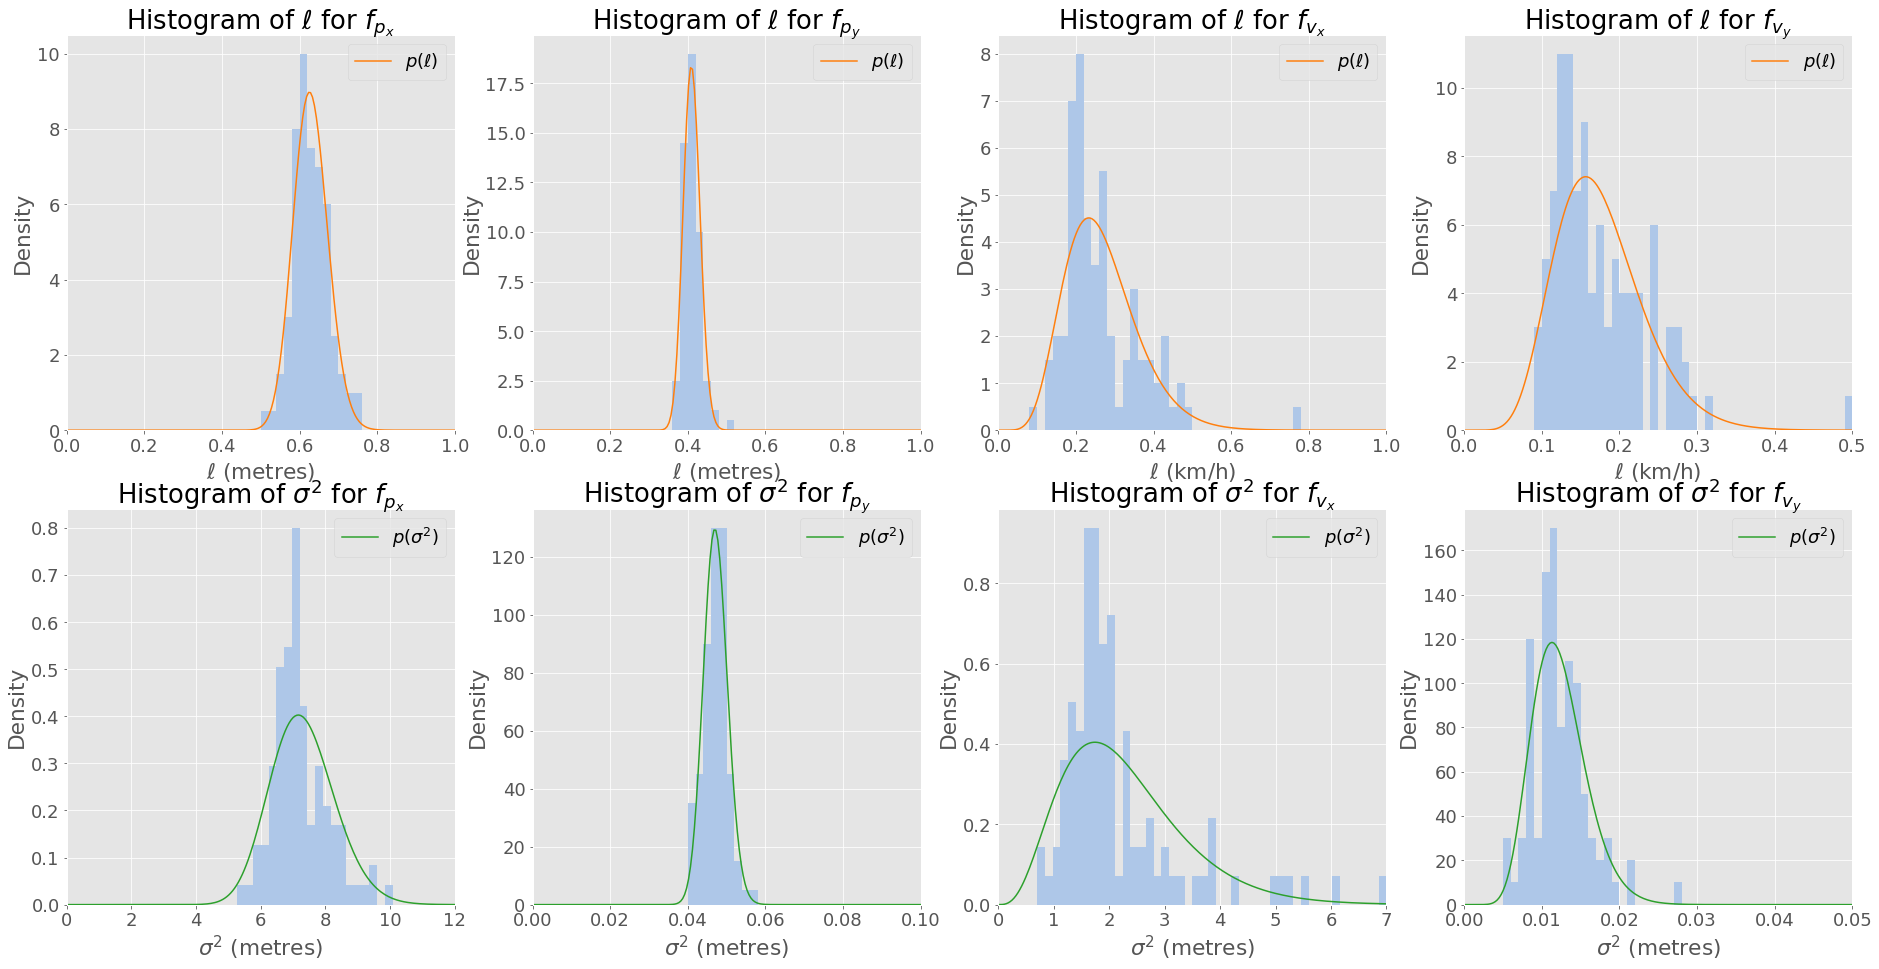

In [37]:
print(len(hyp_traj_ids))
print(len(hyp_seg_ids))
from model.plotting import plot_grid, default_color
from scipy.stats import gamma

plt.rcParams.update({'font.size': 18})

def plot_estimated_prior(ax, plot_range, hist_data, quantity, fit_color, f, unit):
    ax.hist(hist_data, range=plot_range, bins=50, density=True, color=hist_color)
    fit_alpha, fit_loc, fit_beta = gamma.fit(hist_data, floc=0)
    xx = np.linspace(plot_range[0], plot_range[1], 200)
    yy = gamma.pdf(xx, fit_alpha, fit_loc, fit_beta)
    ax.plot(xx, yy, label='$p($' + quantity +'$)$', color=fit_color)
    ax.set_xlabel(quantity + ' (' + unit +')')
    ax.set_xlim(plot_range)
    ax.set_title(r'Histogram of ' + quantity + ' for $' + f +'$')
    ax.set_ylabel(r'Density')
    ax.legend()
    print('${}$ {} parameters: $\\alpha$={} $\\beta$={}'.format(f, quantity,fit_alpha, fit_beta))

    
_, axs = plot_grid(2, 4 )
fpx_ell_ax = axs[0, 0]
fpx_var_ax = axs[1, 0]
fpy_ell_ax = axs[0, 1]
fpy_var_ax = axs[1, 1]
fvx_ell_ax = axs[0, 2]
fvx_var_ax = axs[1, 2]
fvy_ell_ax = axs[0, 3]
fvy_var_ax = axs[1, 3]

resolution = 300
hist_color = default_color(1)
ell_color = default_color(2)
var_color = default_color(4)
ell_hist_label = r'$\ell$'
ell_fit_label = r'Estiamted $p(\ell)$'

seg_n = 0
fpx_range = (0, 1)
plot_estimated_prior(fpx_ell_ax, fpx_range, ls[0, seg_n], ell_hist_label, ell_color, 'f_{p_x}', 'metres')
fpy_range = (0, 1)
plot_estimated_prior(fpy_ell_ax, fpy_range, ls[1, seg_n], ell_hist_label, ell_color, 'f_{p_y}', 'metres')
fvx_range = (0, 1)
fvx_ls_kmh = np.array(fvx_ls)*3.6
plot_estimated_prior(fvx_ell_ax, fvx_range, ls[2, seg_n], ell_hist_label, ell_color, 'f_{v_x}', 'km/h')
fvy_range = (0, .5)
fvy_ls_kmh = np.array(fvy_ls)*3.6
plot_estimated_prior(fvy_ell_ax, fvy_range, ls[3, seg_n], ell_hist_label, ell_color, 'f_{v_y}', 'km/h')

var_hist_label = r'$\sigma^2$'

fpx_var_range = (0, 12)
plot_estimated_prior(fpx_var_ax, fpx_var_range, vars[0, seg_n], var_hist_label, var_color, 'f_{p_x}', 'metres')
fpy_var_range = (0, .1)
plot_estimated_prior(fpy_var_ax, fpy_var_range, vars[1, seg_n], var_hist_label, var_color, 'f_{p_y}', 'metres')
fvx_var_range = (0, 7)
fvx_var_kmh = np.array(fvx_var)*3.6
plot_estimated_prior(fvx_var_ax, fvx_var_range, vars[2, seg_n], var_hist_label, var_color, 'f_{v_x}', 'metres')

fvy_var_range = (0, 0.05)
fvy_var_kmh = np.array(fvy_var)*3.6
plot_estimated_prior(fvy_var_ax, fvy_var_range, vars[3, seg_n], var_hist_label, var_color, 'f_{v_y}', 'metres')

$f_{p_x}$ $\ell$ parameters: $\alpha$=0.4535984866180475 $\beta$=5.95689466158176

$f_{p_y}$ $\ell$ parameters: $\alpha$=0.1497037731343836 $\beta$=3.95908043440209

$f_{v_x}$ $\ell$ parameters: $\alpha$=2.1375357609511085 $\beta$=1.3298621485622508

$f_{v_y}$ $\ell$ parameters: $\alpha$=0.7728656323799816 $\beta$=0.013162814492013066

$f_{p_x}$ $\sigma^2$ parameters: $\alpha$=2.0166671257004736 $\beta$=0.43416059060187423

$f_{p_y}$ $\sigma^2$ parameters: $\alpha$=0.1497037731343836 $\beta$=3.95908043440209

$f_{v_x}$ $\sigma^2$ parameters: $\alpha$=0.14970377313438363 $\beta$=14.25268956384752

$f_{v_y}$ $\sigma^2$ parameters: $\alpha$=0.7728656323799816 $\beta$=0.013162814492013066

In [41]:
n_segs, n_models, n_params = len(hyp_seg_ids), 6, 3
params = np.array(n_segs, n_models, n_params)

#ls = np.ndarray((6, len(hyp_seg_ids), len(hyp_traj_ids)))
#vars = np.ndarray((6, len(hyp_seg_ids), len(hyp_traj_ids)))
#lins = np.ndarray((2, len(hyp_seg_ids), len(hyp_traj_ids)))

for i, seg_id in enumerate(hyp_seg_ids):
    fpx_l_alpha, _, fpx_l_beta = gamma.fit(ls[0, i], floc=0)
    fpy_l_alpha, _, fpy_l_beta = gamma.fit(ls[1, i], floc=0)
    fvx_l_alpha, _, fvx_l_beta = gamma.fit(ls[2, i], floc=0)
    fvy_l_alpha, _, fvy_l_beta = gamma.fit(ls[3, i], floc=0)
    g_l_alpha, _, g_l_beta = gamma.fit(ls[4, i], floc=0)
    h_l_alpha, _, h_l_beta = gamma.fit(ls[5, i], floc=0)
    params[i, 0, 0] = fpx_l_alpha
    

(6, 22, 100)


ValueError: Must pass 2-d input